In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import csv
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from shapely.ops import cascaded_union
from folium import Marker, PolyLine
from folium.plugins import HeatMap, HeatMapWithTime, MarkerCluster
import geopandas as gpd
from shapely.geometry import Point, LineString
from scipy.optimize import curve_fit
from math import log10, sqrt, exp

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, r2_score, matthews_corrcoef)
import matplotlib.pyplot as plt
from functools import partial
from pyswarm import pso



In [2]:
earthquakes_japan = pd.read_csv('earthquake_data_japan.csv')

earthquakes_japan.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unnamed: 22
0,1980-01-03T19:58:07.800Z,28.485,128.381,134.0,5.4,mb,NaN,NaN,NaN,NaN,...,"108 km W of Naze, Japan",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,1980
1,1980-01-04T16:42:08.500Z,42.601,144.428,93.0,5.1,mb,NaN,NaN,NaN,NaN,...,"41 km S of Kushiro, Japan",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,1980
2,1980-01-07T16:45:29.900Z,37.464,143.028,33.0,4.7,mb,NaN,NaN,NaN,NaN,...,"179 km E of Namie, Japan",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,1980
3,1980-01-07T23:44:26.000Z,40.168,124.978,10.0,5.0,mb,NaN,NaN,NaN,NaN,...,"25 km SSW of Sakchu-?p, North Korea",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,1980
4,1980-01-10T03:47:42.700Z,26.669,126.536,99.0,4.9,mb,NaN,NaN,NaN,NaN,...,"124 km WNW of Naha, Japan",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,1980


In [3]:

# Define the ranges
ranges = [(1, 1.9), (2, 2.9), (3, 3.9), (4, 4.9), (5, 5.9), (6, 6.9), (7, 7.9), (8, 8.9), (9, 9.9)]

# Count the occurrences within each range
counts = {}

for start, end in ranges:
    count = earthquakes_japan[(earthquakes_japan['mag'] >= start) & (earthquakes_japan['mag'] < end + 0.1)].shape[0]
    counts[f"{start}-{end}"] = count
    
# Print the results
for range_str, count in counts.items():
    print(f"Count of mag in range {range_str}: {count}")

Count of mag in range 1-1.9: 3
Count of mag in range 2-2.9: 22
Count of mag in range 3-3.9: 3201
Count of mag in range 4-4.9: 31149
Count of mag in range 5-5.9: 4556
Count of mag in range 6-6.9: 420
Count of mag in range 7-7.9: 40
Count of mag in range 8-8.9: 1
Count of mag in range 9-9.9: 1


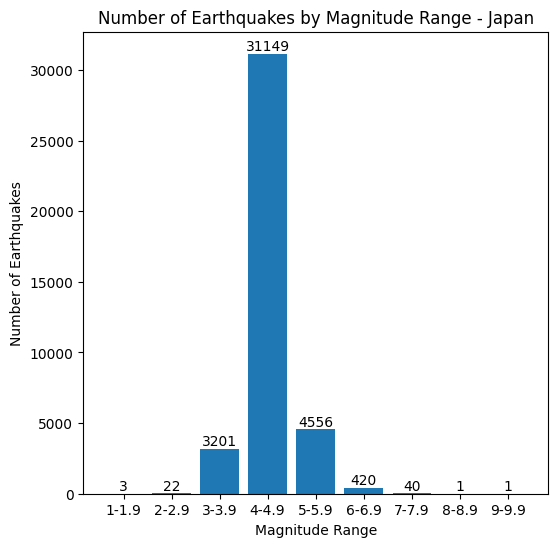

In [4]:


# Define the ranges
ranges = [(1, 1.9), (2, 2.9), (3, 3.9), (4, 4.9), (5, 5.9), (6, 6.9), (7, 7.9), (8, 8.9), (9, 9.9)]

# Count the occurrences within each range
counts = {}

for start, end in ranges:
    count = earthquakes_japan[(earthquakes_japan['mag'] >= start) & (earthquakes_japan['mag'] < end + 0.1)].shape[0]
    counts[f"{start}-{end}"] = count

# Prepare data for plotting
mag_ranges = list(counts.keys())
num_earthquakes = list(counts.values())

# Create the bar plot
plt.figure(figsize=(6, 6))
bars = plt.bar(mag_ranges, num_earthquakes)
plt.xlabel('Magnitude Range')
plt.ylabel('Number of Earthquakes')
plt.title('Number of Earthquakes by Magnitude Range - Japan')

# Annotate the bars
for bar in bars:
    height = bar.get_height()
    plt.gca().text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')

# Display the plot
plt.show()


In [5]:
earthquakes_japan.dtypes

time                object
latitude           float64
longitude          float64
depth              float64
mag                float64
magType             object
nst                float64
gap                float64
dmin               float64
rms                float64
net                 object
id                  object
updated             object
place               object
type                object
horizontalError    float64
depthError         float64
magError           float64
magNst             float64
status              object
locationSource      object
magSource           object
Unnamed: 22          int64
dtype: object

In [6]:
earthquakes_japan['time'] = pd.to_datetime(earthquakes_japan['time'])

In [7]:
earthquakes_japan.dtypes

time               datetime64[ns, UTC]
latitude                       float64
longitude                      float64
depth                          float64
mag                            float64
magType                         object
nst                            float64
gap                            float64
dmin                           float64
rms                            float64
net                             object
id                              object
updated                         object
place                           object
type                            object
horizontalError                float64
depthError                     float64
magError                       float64
magNst                         float64
status                          object
locationSource                  object
magSource                       object
Unnamed: 22                      int64
dtype: object

In [8]:
earthquakes_japan.isnull().sum()

time                   0
latitude               0
longitude              0
depth                  0
mag                    0
magType                0
nst                19873
gap                13684
dmin               29569
rms                 1268
net                    0
id                     0
updated                0
place                 81
type                   0
horizontalError    30771
depthError         15146
magError           29724
magNst              6142
status                 0
locationSource         0
magSource              0
Unnamed: 22            0
dtype: int64

In [9]:
earthquakes_japan = earthquakes_japan.drop(['nst','gap', 'rms','horizontalError','depthError','dmin', 'magError', 'magNst','magType','net','id','updated','place','status','locationSource','magSource','type'], axis=1)

In [10]:
# earthquakes_cali.isnull().sum()
earthquakes_japan.isnull().sum()

time           0
latitude       0
longitude      0
depth          0
mag            0
Unnamed: 22    0
dtype: int64

In [11]:
earthquakes_japan.shape

(39393, 6)

### Calculating the Cut-off magnitudes

Cut-off magnitude: 4.35


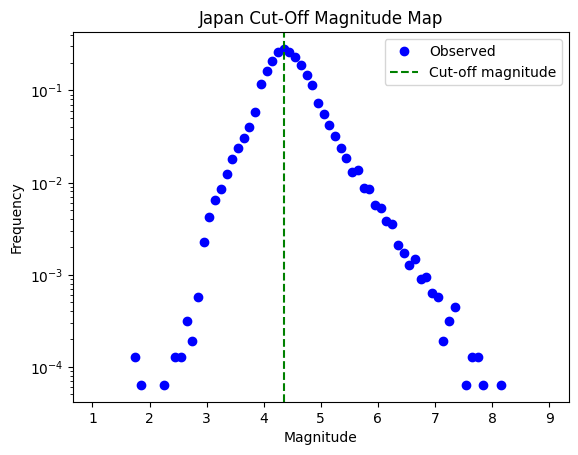

In [12]:
start_time = "1980-01-01"
end_time = "2023-02-28"
min_magnitude = 1.0

# Convert start_time and end_time to datetime objects
start_time = datetime.strptime(start_time, '%Y-%m-%d')
end_time = datetime.strptime(end_time, '%Y-%m-%d')

# Calculate the duration between start_time and end_time
duration = end_time - start_time

# 4. Compute the frequency-magnitude distribution
magnitude_bins = np.arange(min_magnitude, earthquakes_japan["mag"].max(), 0.1)
hist, edges = np.histogram(earthquakes_japan["mag"], bins=magnitude_bins)
hist = hist / duration.days
magnitudes = (edges[1:] + edges[:-1]) / 2

# 5. Fit the Gutenberg-Richter law to the data
def gutenberg_richter(magnitude, a, b):
    return 10 ** (a - b * magnitude)

popt, pcov = curve_fit(gutenberg_richter, magnitudes, hist)

# 6. Determine the point of deviation
residuals = np.abs(hist - gutenberg_richter(magnitudes, *popt))
cutoff_magnitude_japan = magnitudes[np.argmax(residuals)]

print("Cut-off magnitude:", round(cutoff_magnitude_japan, 3))

# Optional: Plot the results
plt.plot(magnitudes, hist, "bo", label="Observed")
# plt.plot(magnitudes, gutenberg_richter(magnitudes, *popt), "r-", label="Gutenberg-Richter fit")
plt.axvline(cutoff_magnitude_japan, color="g", linestyle="--", label="Cut-off magnitude")
plt.title("Japan Cut-Off Magnitude Map")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.yscale("log")
plt.legend()
plt.show()


### Removing the data below the cut-off magnitudes

In [13]:

earthquakes_japan_cutoff = earthquakes_japan[earthquakes_japan['mag'] >= cutoff_magnitude_japan]


print("Japan Data Dimensions: ", earthquakes_japan.shape)

print("\nJapan Cut-off Data Dimensions: ", earthquakes_japan_cutoff.shape)

Japan Data Dimensions:  (39393, 6)

Japan Cut-off Data Dimensions:  (24388, 6)


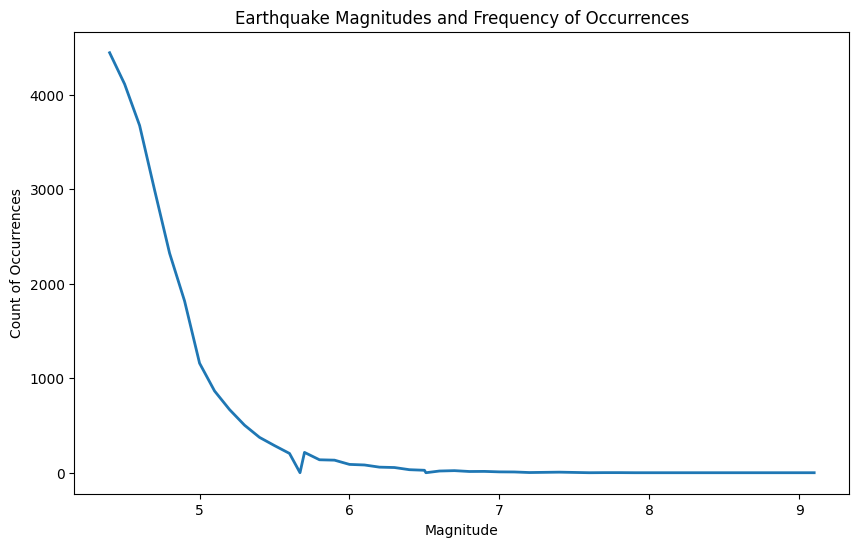

In [14]:
# Calculate the frequency of occurrences for different magnitudes
magnitude_counts = earthquakes_japan_cutoff['mag'].value_counts().sort_index().reset_index()
magnitude_counts.columns = ['magnitude', 'count']

plt.figure(figsize=(10, 6))

# Plot the curve using a line without dots
plt.plot(magnitude_counts['magnitude'], magnitude_counts['count'], linestyle='-', linewidth=2)

plt.xlabel('Magnitude')
plt.ylabel('Count of Occurrences')
plt.title('Earthquake Magnitudes and Frequency of Occurrences')
plt.show()


Cut-off magnitude: 4.350000000000003


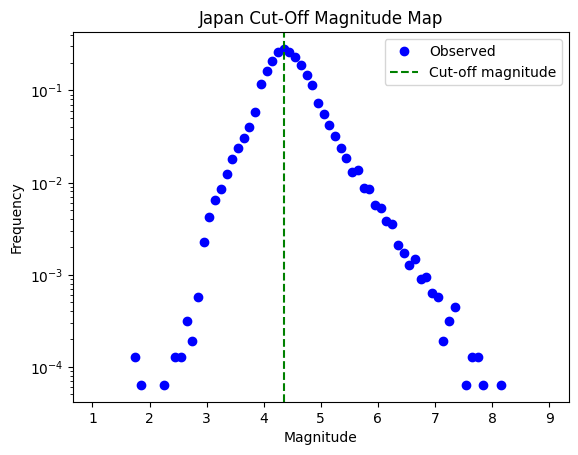

In [15]:
start_time = "1980-01-01"
end_time = "2023-02-28"
# min_magnitude = 1.0

# Convert start_time and end_time to datetime objects
start_time = datetime.strptime(start_time, '%Y-%m-%d')
end_time = datetime.strptime(end_time, '%Y-%m-%d')

# Calculate the duration between start_time and end_time
duration = end_time - start_time

# 4. Compute the frequency-magnitude distribution
magnitude_bins = np.arange(min_magnitude, earthquakes_japan["mag"].max(), 0.1)
hist, edges = np.histogram(earthquakes_japan["mag"], bins=magnitude_bins)
hist = hist / duration.days
magnitudes = (edges[1:] + edges[:-1]) / 2

# 5. Fit the Gutenberg-Richter law to the data
def gutenberg_richter(magnitude, a, b):
    return 10 ** (a - b * magnitude)

popt, pcov = curve_fit(gutenberg_richter, magnitudes, hist)

# 6. Determine the point of deviation
residuals = np.abs(hist - gutenberg_richter(magnitudes, *popt))
cutoff_magnitude_japan = magnitudes[np.argmax(residuals)]

print("Cut-off magnitude:", cutoff_magnitude_japan)

# Optional: Plot the results
plt.plot(magnitudes, hist, "bo", label="Observed")
# plt.plot(magnitudes, gutenberg_richter(magnitudes, *popt), "r-", label="Gutenberg-Richter fit")
plt.axvline(cutoff_magnitude_japan, color="g", linestyle="--", label="Cut-off magnitude")
plt.title("Japan Cut-Off Magnitude Map")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.yscale("log")
plt.legend()
plt.show()


### Feature Calculation

In [16]:
# Create a new DataFrame to avoid modifying the original
earthquakes_japan_cutoff_copy = earthquakes_japan_cutoff.copy()

# Add a 'prediction' column to the DataFrame
earthquakes_japan_cutoff_copy['prediction'] = (earthquakes_japan_cutoff_copy['mag'] >= 5.0).astype(int)


In [17]:
prediction_counts = earthquakes_japan_cutoff_copy['prediction'].value_counts()
print(prediction_counts)

0    19370
1     5018
Name: prediction, dtype: int64


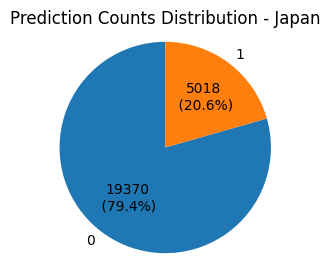

In [18]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{v:d}\n ({p:.1f}%)'.format(v=val, p=pct)
    return my_autopct

prediction_counts = earthquakes_japan_cutoff_copy['prediction'].value_counts()

# Plot the pie chart
plt.figure(figsize=(3, 3))
plt.pie(prediction_counts, labels=['0', '1'], autopct=make_autopct(prediction_counts), startangle=90)
plt.title('Prediction Counts Distribution - Japan')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [19]:

df = earthquakes_japan_cutoff_copy

# Gutenberg-Richter function 
def gutenberg_richter(magnitudes):
    M = np.array(magnitudes)
    N = len(M)
    b = (1 / (np.log(10) * N)) * np.sum(M - np.min(M) + 1)
    a = np.log10(N) + b * np.min(M)
    return a, b

# Seismic energy release function
def seismic_energy_release(magnitudes, T, T_prev):
    if T == 0:
        return seismic_energy_release(magnitudes, T_prev, T_prev)

    M = np.array(magnitudes)
    E = np.sum(10 ** (11.8 + 1.5 * M))
    dE = E / T
    sqrt_dE = np.sqrt(dE)
    return sqrt_dE



def calculate_features(df):
    features = []

    T_prev = None

    for index, row in df.iterrows():
        if row['mag'] < 5.0:
            continue

        df_n = df.loc[df['time'].between(row['time'] - pd.Timedelta(days=50), row['time'], inclusive='neither')].tail(50)
        T = (df_n.iloc[-1]['time'] - df_n.iloc[0]['time']).days

        if T == 0:
            if T_prev is None:
                continue
            else:
                T = T_prev

        magnitudes = df_n['mag'].values
        a, b = gutenberg_richter(magnitudes)

        sqrt_dE = seismic_energy_release(magnitudes, T, T_prev)

        T_prev = T

        Mmean = np.mean(magnitudes)

        max_mag_7 = df_n[df_n['time'] >= (row['time'] - pd.Timedelta(days=7))]['mag'].max()
        if np.isnan(max_mag_7):
            max_mag_7 = row['mag']


        M_max_exp = a / b
        M_def = row['mag'] - M_max_exp

        eta = sum([(log10(i+1) - a - b * M) ** 2 for i, M in enumerate(sorted(magnitudes, reverse=True))]) / (len(magnitudes) - 1)

        # Calculate the new features
        Tr = T / (10 ** (a - b * row['mag']))
        sigma_b = ((2.3 * (b ** 2)) * (np.sqrt(np.sum((magnitudes - Mmean) ** 2) / (len(magnitudes) * (len(magnitudes) - 1)))))
        x_mag6 = exp((-3 * b) / log10(exp(1)))

        # Append new features to the existing list
        features.append([row['time'], row['mag'], T, a, b, sqrt_dE, Mmean, max_mag_7, M_def, eta, Tr, sigma_b, x_mag6])

    feature_columns = ['time', 'mag', 'T', 'a', 'b', 'sqrt_dE', 'Mmean', 'max_mag_7', 'M_def', 'eta', 'Tr', 'sigma_b', 'x_mag6']
    df_features = pd.DataFrame(features, columns=feature_columns)

    return df_features


### Removing Irrelavant Features

In [20]:
df = earthquakes_japan_cutoff_copy

# Gutenberg-Richter function 
def gutenberg_richter(magnitudes):
    M = np.array(magnitudes)
    N = len(M)
    b = (1 / (np.log(10) * N)) * np.sum(M - np.min(M) + 1)
    a = np.log10(N) + b * np.min(M)
    return a, b

# Seismic energy release function
def seismic_energy_release(magnitudes, T, T_prev):
    if T == 0:
        return seismic_energy_release(magnitudes, T_prev, T_prev)

    M = np.array(magnitudes)
    E = np.sum(10 ** (11.8 + 1.5 * M))
    dE = E / T
    sqrt_dE = np.sqrt(dE)
    return sqrt_dE



def calculate_features(df):
    features = []

    T_prev = None

    for index, row in df.iterrows():
        df_n = df.loc[df['time'].between(row['time'] - pd.Timedelta(days=50), row['time'], inclusive='neither')].tail(50)

        # Check if there are enough rows in df_n
        if len(df_n) < 2:
            continue

        T = (df_n.iloc[-1]['time'] - df_n.iloc[0]['time']).days

        if T == 0:
            if T_prev is None:
                continue
            else:
                T = T_prev

        magnitudes = df_n['mag'].values
        a, b = gutenberg_richter(magnitudes)

        sqrt_dE = seismic_energy_release(magnitudes, T, T_prev)

        T_prev = T

        Mmean = np.mean(magnitudes)

        max_mag_7 = df_n[df_n['time'] >= (row['time'] - pd.Timedelta(days=7))]['mag'].max()
        if np.isnan(max_mag_7):
            max_mag_7 = row['mag']

        M_max_exp = a / b
        M_def = row['mag'] - M_max_exp

        eta = sum([(log10(i+1) - a - b * M) ** 2 for i, M in enumerate(sorted(magnitudes, reverse=True))]) / (len(magnitudes) - 1)

        Tr = T / (10 ** (a - b * row['mag']))
        sigma_b = ((2.3 * (b ** 2)) * (np.sqrt(np.sum((magnitudes - Mmean) ** 2) / (len(magnitudes) * (len(magnitudes) - 1)))))
        x_mag6 = exp((-3 * b) / log10(exp(1)))

        features.append([row['time'], row['mag'], T, a, b, sqrt_dE, Mmean, max_mag_7, M_def, eta, Tr, sigma_b, x_mag6])

    feature_columns = ['time', 'mag', 'T', 'a', 'b', 'sqrt_dE', 'Mmean', 'max_mag_7', 'M_def', 'eta', 'Tr', 'sigma_b', 'x_mag6']
    df_features = pd.DataFrame(features, columns=feature_columns)

    return df_features

df_final = calculate_features(df)



# irrel_filter function
def irrel_filter(featSet, Target, L):
    MI = np.zeros(featSet.shape[1])
    epsilon = 1e-10  # Small constant to avoid division by zero
    
    for j in range(featSet.shape[1]):
        U = np.zeros(2)
        U1 = np.zeros(2)
        U2 = np.zeros(2)
        U3 = np.zeros(2)
        
        for i in range(Target.shape[0]):
            if Target[i] == 0:
                U[0] += 1
                if featSet[i, j] == 0:
                    U1[0] += 1
                else:
                    U2[0] += 1
            else:
                U[1] += 1
                if featSet[i, j] == 0:
                    U1[1] += 1
                else:
                    U2[1] += 1
        
        U3 = U - (U1 + U2)
        p_targ_0 = (U[0] + epsilon) / L
        p_targ_1 = (U[1] + epsilon) / L
        p_temp_0 = (np.sum(U1) + epsilon) / L
        p_temp_1 = (np.sum(U2) + epsilon) / L
        p_targ0_temp0 = (U1[0] + epsilon) / L
        p_targ1_temp0 = (U1[1] + epsilon) / L
        p_targ0_temp1 = (U2[0] + epsilon) / L
        p_targ1_temp1 = (U2[1] + epsilon) / L
        
        MI[j] = p_targ0_temp0 * np.log2(p_targ0_temp0 / (p_targ_0 * p_temp_0)) + \
                p_targ1_temp0 * np.log2(p_targ1_temp0 / (p_targ_1 * p_temp_0)) + \
                p_targ0_temp1 * np.log2(p_targ0_temp1 / (p_targ_0 * p_temp_1)) + \
                p_targ1_temp1 * np.log2(p_targ1_temp1 / (p_targ_1 * p_temp_1))

    filtered_indices = np.where(MI >= np.median(MI))[0]
    filtered_featSet = featSet[:, filtered_indices]

    return MI, filtered_featSet


# Prepare input for the irrel_filter function
featSet = df_final.drop(columns=['time', 'mag']).values
Target = np.where(df_final['mag'] >= 6, 1, 0)
L = len(Target)

# Apply the irrel_filter function
MI, filtered_featSet = irrel_filter(featSet, Target, L)

# Update the DataFrame with the filtered features
filtered_columns = df_final.drop(columns=['time', 'mag']).columns[MI >= np.median(MI)]
df_filtered = pd.DataFrame(filtered_featSet, columns=filtered_columns)
df_filtered['time'] = df_final['time']
df_filtered['mag'] = df_final['mag']

# df_filtered.to_csv('filtered_data.csv', index=False)


In [21]:
df_filtered

,T,a,b,sqrt_dE,Mmean,max_mag_7,M_def,eta,Tr,sigma_b,x_mag6,time,mag
0,3.0,3.266739,0.593536,6.183206e+09,5.066667,5.4,-0.803863,54.462728,1.000000,0.164286,0.016573,1980-01-07 16:45:29.900000+00:00,4.7
1,4.0,3.357658,0.586298,5.801912e+09,5.050000,5.4,-0.726885,47.758091,1.499303,0.114115,0.017422,1980-01-07 23:44:26+00:00,5.0
2,6.0,3.393333,0.573269,4.979527e+09,5.020000,5.4,-1.019271,43.034602,1.562554,0.087498,0.019063,1980-01-10 03:47:42.700000+00:00,4.9
3,7.0,3.676343,0.658680,4.648901e+09,4.916667,5.1,-1.181380,50.004486,1.166667,0.139742,0.010567,1980-01-11 08:36:20.500000+00:00,4.4
4,7.0,3.602248,0.626625,4.687337e+09,4.842857,5.1,-1.348651,43.799302,1.000000,0.125970,0.013186,1980-01-11 14:55:47.600000+00:00,4.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24381,41.0,4.102877,0.546342,7.736348e+09,4.658000,5.1,-3.109716,29.634448,0.820000,0.035853,0.022960,2023-02-25 09:16:38.620000+00:00,4.4
24382,41.0,4.121986,0.550685,7.762164e+09,4.668000,5.1,-2.485192,30.130878,1.754790,0.036661,0.022281,2023-02-25 10:25:44.311000+00:00,5.0
24383,41.0,4.152560,0.557634,8.641146e+09,4.684000,6.0,-1.446747,30.957286,6.397767,0.041495,0.021237,2023-02-25 13:27:43.393000+00:00,6.0
24384,41.0,4.137273,0.554160,8.620035e+09,4.676000,6.0,-2.865849,30.552288,1.058390,0.040740,0.021753,2023-02-26 14:55:45.670000+00:00,4.6


In [22]:
# df_final.shape,earthquakes_chile_cutoff.shape

##### THE MODEL

In [24]:
# Check if there are any infinite values in the dataset
infinite_mask = earthquakes_japan_cutoff_copy.applymap(np.isinf)
if infinite_mask.values.any():
    print("Infinite values found:")
    print(infinite_mask.sum())


TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [25]:

def predict_ann(X, ann_weights, threshold=0.5):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    binary_output = (layer_output.squeeze() > threshold).astype(int)
    return binary_output


def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights))

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights


def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    input_size = X_train.shape[1]

    # Get the weights for each layer
    ann_weights = []
    start = 0
    for i, layer_size in enumerate(layer_sizes):
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    # Initialize the input and output of each layer
    layer_input = X_train
    for i in range(len(layer_sizes)):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, ann_weights[i].T))
        layer_input = layer_output

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train) ** 2)
    return mse


# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)


# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_test_pred.round())
print("Accuracy:", accuracy)


Stopping search: Swarm best objective change less than 1e-08
Accuracy: 0.9983597594313832


In [26]:
y_train.shape

(17070,)

#### Performance Measures

Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 100
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average accuracy: 0.99155289830528
Average precision: 0.9814686545374617
Average recall: 0.9774761373250765
Average F1-score: 0.9794432971195111
Average ROC AUC: 0.9863374491478248


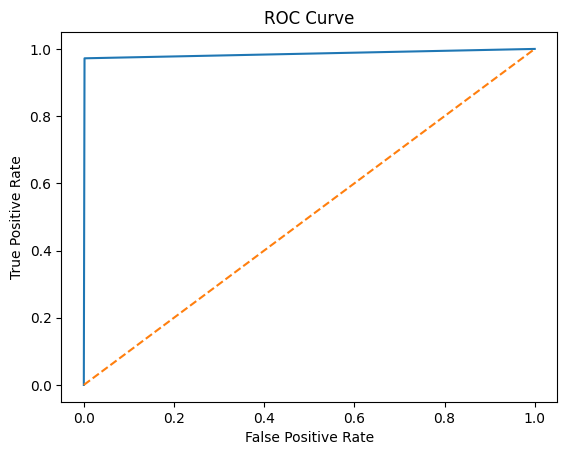

In [27]:
def predict_ann(X, ann_weights, threshold=0.5):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    binary_output = (layer_output.squeeze() > threshold).astype(int)
    return binary_output


def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights))

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights


def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    input_size = X_train.shape[1]

    # Get the weights for each layer
    ann_weights = []
    start = 0
    for i, layer_size in enumerate(layer_sizes):
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    # Initialize the input and output of each layer
    layer_input = X_train
    for i in range(len(layer_sizes)):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, ann_weights[i].T))
        layer_input = layer_output

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train) ** 2)
    return mse

# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered_copy.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)


# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)


# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize performance metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []

# Perform k-fold cross-validation
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)

    # Append performance metrics to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)

# Calculate average performance metrics
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)

print("Average accuracy:", avg_accuracy)
print("Average precision:", avg_precision)
print("Average recall:", avg_recall)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


### Modified Performance Measures

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average accuracy: 0.9956532923951343
Average precision: 0.9979641696585556
Average recall: 0.9808623929009783
Average F1-score: 0.9893119433979936
Average ROC AUC: 0.9901730653198749
Average R2 Score: 0.9733963922005229
Average NPV: 0.9950733694883563
Average PPV: 0.9979641696585556
Average Specificity: 0.9994837377387713
Average Matthews Correlation Coefficient: 0.9866638145777051


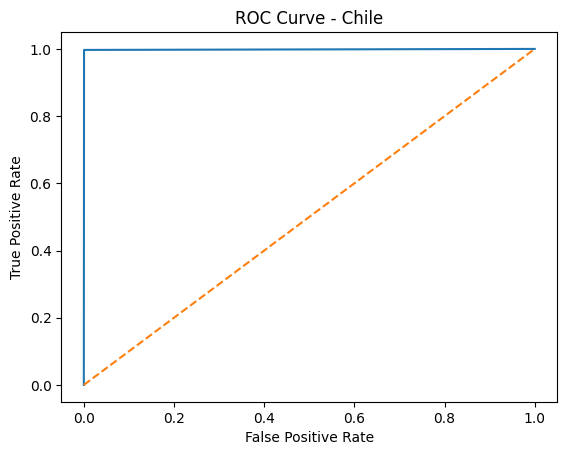

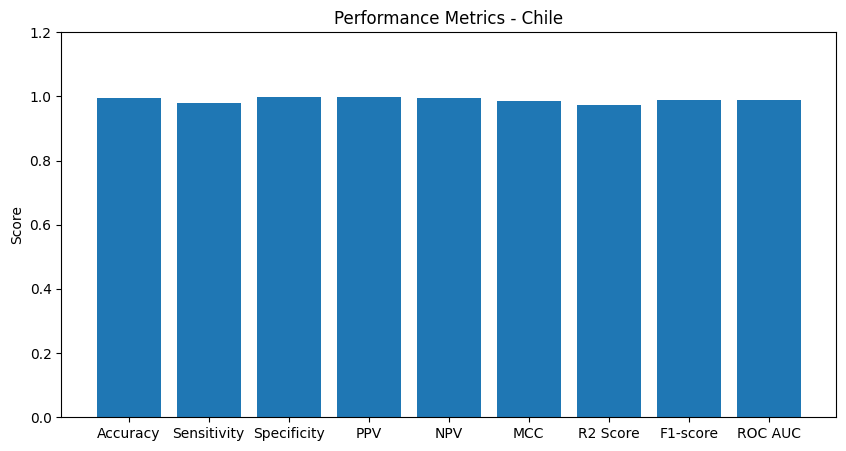

<Figure size 640x480 with 0 Axes>

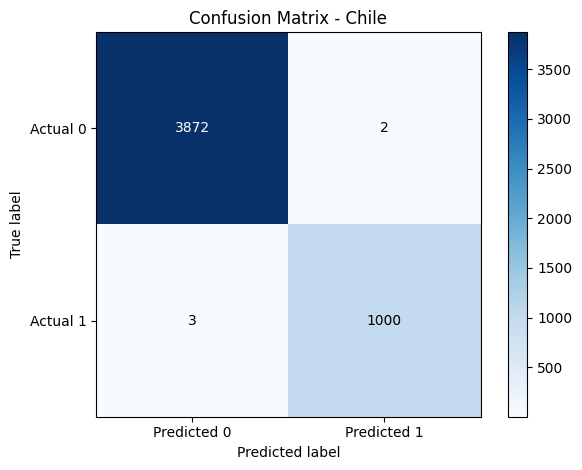

In [28]:

np.seterr(divide='ignore', invalid='ignore')  # Add this line to ignore RuntimeWarnings


def predict_ann(X, ann_weights, threshold=0.6):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    binary_output = (layer_output.squeeze() > threshold).astype(int)
    return binary_output


def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights))

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights


def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    input_size = X_train.shape[1]

    # Get the weights for each layer
    ann_weights = []
    start = 0
    for i, layer_size in enumerate(layer_sizes):
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    # Initialize the input and output of each layer
    layer_input = X_train
    for i in range(len(layer_sizes)):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, ann_weights[i].T))
        layer_input = layer_output

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train) ** 2)
    return mse

# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered_copy.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)

# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
r2_score_list = []
npv_list = []
ppv_list = []
specificity_list = []
mcc_list = []
# log_loss_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)
#     y_test_pred_proba = predict_ann(X_test_hnn, ann_weights, activation='sigmoid').squeeze()

    # Calculate R2 Score
    r2 = r2_score(y_test, y_test_pred)
    r2_score_list.append(r2)

    # Compute confusion matrix elements
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate NPV and specificity
    npv = TN / (TN + FN)
    ppv = TP / (TP + FP)
    specificity = TN / (TN + FP)

    # Calculate MCC and log loss
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)
#     ll = log_loss(y_test, y_test_pred_proba)

    # Append NPV, specificity, MCC, and log loss to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    npv_list.append(npv)
    ppv_list.append(ppv)
    specificity_list.append(specificity)
    mcc_list.append(mcc)
#     log_loss_list.append(ll)

# Calculate average R2 Score, NPV, specificity, MCC, and log loss
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_r2_score = np.mean(r2_score_list)
avg_npv = np.mean(npv_list)
avg_ppv = np.mean(ppv_list)
avg_specificity = np.mean(specificity_list)
avg_mcc = np.mean(mcc_list)
# avg_log_loss = np.mean(log_loss_list)

print("Average accuracy:", avg_accuracy)
print("Average precision:", avg_precision)
print("Average recall:", avg_recall)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)
print("Average R2 Score:", avg_r2_score)
print("Average NPV:", avg_npv)
print("Average PPV:", avg_ppv)
print("Average Specificity:", avg_specificity)
print("Average Matthews Correlation Coefficient:", avg_mcc)
# print("Average Log Loss:", avg_log_loss)

def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'],
           title="Confusion Matrix - Chile",
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


# Plot the performance metrics
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'MCC', 'R2 Score', 'F1-score', 'ROC AUC']
metric_values = [avg_accuracy, avg_recall, avg_specificity, avg_ppv, avg_npv, avg_mcc, avg_r2_score, avg_f1, avg_roc_auc]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Chile")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(metrics, metric_values)
plt.title("Performance Metrics - Chile")
plt.ylabel("Score")
plt.ylim((0, 1.2))
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm)
plt.show()


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average accuracy: 0.9927831039639082
Average precision: 0.9932898491798883
Average recall: 0.9715000417075468
Average F1-score: 0.982125852846082
Average ROC AUC: 0.9848981881227459
Average R2 Score: 0.9558345597244143
Average NPV: 0.992695094361687
Average PPV: 0.9932898491798883
Average Specificity: 0.9982963345379453
Average Matthews Correlation Coefficient: 0.9778154834144743


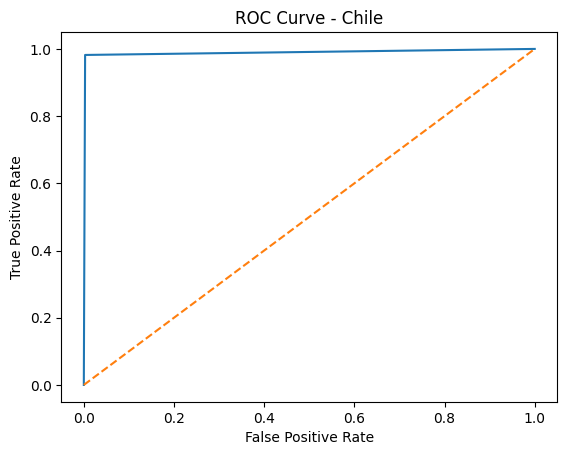

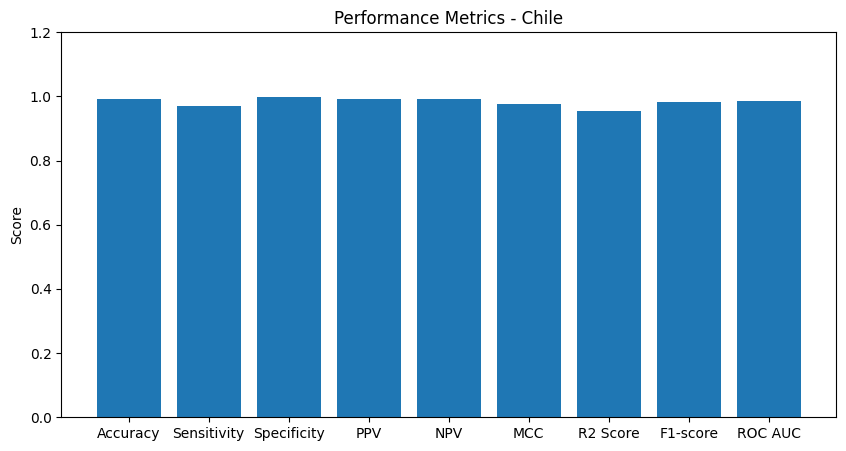

<Figure size 640x480 with 0 Axes>

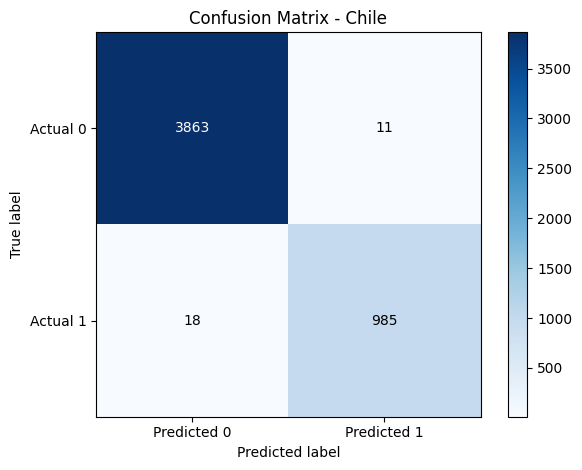

In [29]:
np.seterr(divide='ignore', invalid='ignore')  # Add this line to ignore RuntimeWarnings


def predict_ann(X, ann_weights, threshold=0.6):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    binary_output = (layer_output.squeeze() > threshold).astype(int)
    return binary_output


def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights))

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights


def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    input_size = X_train.shape[1]

    # Get the weights for each layer
    ann_weights = []
    start = 0
    for i, layer_size in enumerate(layer_sizes):
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    # Initialize the input and output of each layer
    layer_input = X_train
    for i in range(len(layer_sizes)):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, ann_weights[i].T))
        layer_input = layer_output

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train) ** 2)
    return mse

# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)

# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
r2_score_list = []
npv_list = []
ppv_list = []
specificity_list = []
mcc_list = []
# log_loss_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)
#     y_test_pred_proba = predict_ann(X_test_hnn, ann_weights, activation='sigmoid').squeeze()

    # Calculate R2 Score
    r2 = r2_score(y_test, y_test_pred)
    r2_score_list.append(r2)

    # Compute confusion matrix elements
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate NPV and specificity
    npv = TN / (TN + FN)
    ppv = TP / (TP + FP)
    specificity = TN / (TN + FP)

    # Calculate MCC and log loss
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)
#     ll = log_loss(y_test, y_test_pred_proba)

    # Append NPV, specificity, MCC, and log loss to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    npv_list.append(npv)
    ppv_list.append(ppv)
    specificity_list.append(specificity)
    mcc_list.append(mcc)
#     log_loss_list.append(ll)

# Calculate average R2 Score, NPV, specificity, MCC, and log loss
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_r2_score = np.mean(r2_score_list)
avg_npv = np.mean(npv_list)
avg_ppv = np.mean(ppv_list)
avg_specificity = np.mean(specificity_list)
avg_mcc = np.mean(mcc_list)
# avg_log_loss = np.mean(log_loss_list)

print("Average accuracy:", avg_accuracy)
print("Average precision:", avg_precision)
print("Average recall:", avg_recall)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)
print("Average R2 Score:", avg_r2_score)
print("Average NPV:", avg_npv)
print("Average PPV:", avg_ppv)
print("Average Specificity:", avg_specificity)
print("Average Matthews Correlation Coefficient:", avg_mcc)
# print("Average Log Loss:", avg_log_loss)

def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'],
           title="Confusion Matrix - Chile",
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


# Plot the performance metrics
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'MCC', 'R2 Score', 'F1-score', 'ROC AUC']
metric_values = [avg_accuracy, avg_recall, avg_specificity, avg_ppv, avg_npv, avg_mcc, avg_r2_score, avg_f1, avg_roc_auc]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Chile")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(metrics, metric_values)
plt.title("Performance Metrics - Chile")
plt.ylabel("Score")
plt.ylim((0, 1.2))
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm)
plt.show()


### Splitting Data based on Years for Testing and Training

Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 100
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average accuracy: 0.9873696711131557
Average precision: 0.9882603921458356
Average recall: 0.9499551147354748
Average F1-score: 0.9683911334165615
Average ROC AUC: 0.9735062099232357
Average R2 Score: 0.9226925055511783
Average NPV: 0.9872475242848692
Average PPV: 0.9882603921458356
Average Specificity: 0.9970573051109964
Average Matthews Correlation Coefficient: 0.96105879066972


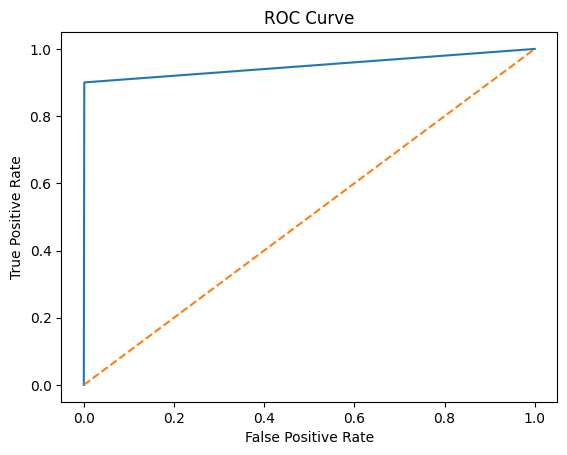

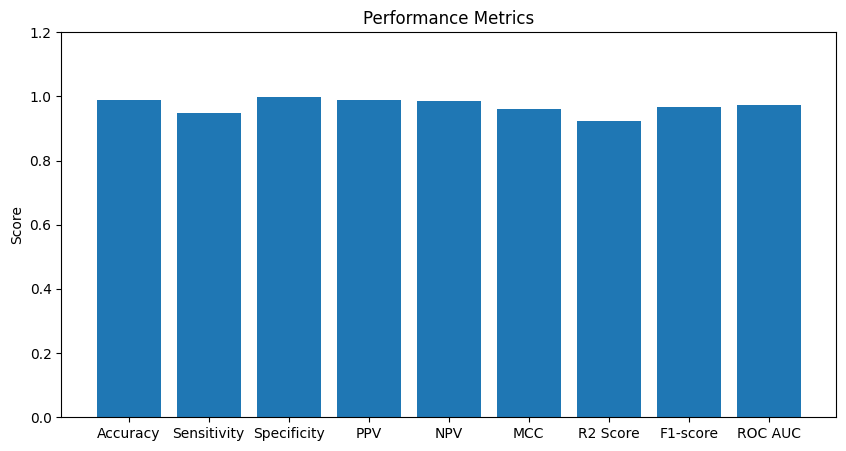

<Figure size 640x480 with 0 Axes>

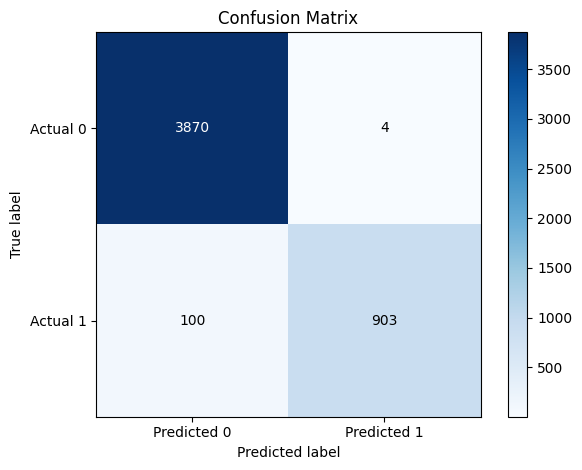

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, r2_score, matthews_corrcoef, log_loss)
import matplotlib.pyplot as plt
from functools import partial
from pyswarm import pso
import seaborn as sns
from datetime import datetime

np.seterr(divide='ignore', invalid='ignore')

# Assume df_filtered_copy already exists
# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered_copy.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Filter data based on the date
split_date = datetime.strptime('2019-01-01', '%Y-%m-%d')
df_filtered_copy['time'] = pd.to_datetime(df_filtered_copy['time']).dt.tz_localize(None)

train_data = df_filtered_copy[df_filtered_copy['time'] < split_date]
test_data = df_filtered_copy[df_filtered_copy['time'] >= split_date]

# Prepare data for the model
X_train = train_data.drop(['time', 'prediction'], axis=1).values
y_train = train_data['prediction'].values
X_test = test_data.drop(['time', 'prediction'], axis=1).values
y_test = test_data['prediction'].values

# print("X Train Shape:", X_train.shape)
# print("\nX Test Shape:", X_test.shape)
# print("\nY Train Shape:", y_train.shape)
# print("\nY Test Shape:", y_test.shape)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)

# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
r2_score_list = []
npv_list = []
ppv_list = []
specificity_list = []
mcc_list = []
# log_loss_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)
#     y_test_pred_proba = predict_ann(X_test_hnn, ann_weights, activation='sigmoid').squeeze()

    # Calculate R2 Score
    r2 = r2_score(y_test, y_test_pred)
    r2_score_list.append(r2)

    # Compute confusion matrix elements
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate NPV and specificity
    npv = TN / (TN + FN)
    ppv = TP / (TP + FP)
    specificity = TN / (TN + FP)

    # Calculate MCC and log loss
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)
#     ll = log_loss(y_test, y_test_pred_proba)

    # Append NPV, specificity, MCC, and log loss to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    npv_list.append(npv)
    ppv_list.append(ppv)
    specificity_list.append(specificity)
    mcc_list.append(mcc)
#     log_loss_list.append(ll)

# Calculate average R2 Score, NPV, specificity, MCC, and log loss
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_r2_score = np.mean(r2_score_list)
avg_npv = np.mean(npv_list)
avg_ppv = np.mean(ppv_list)
avg_specificity = np.mean(specificity_list)
avg_mcc = np.mean(mcc_list)
# avg_log_loss = np.mean(log_loss_list)

print("Average accuracy:", avg_accuracy)
print("Average precision:", avg_precision)
print("Average recall:", avg_recall)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)
print("Average R2 Score:", avg_r2_score)
print("Average NPV:", avg_npv)
print("Average PPV:", avg_ppv)
print("Average Specificity:", avg_specificity)
print("Average Matthews Correlation Coefficient:", avg_mcc)
# print("Average Log Loss:", avg_log_loss)

def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'],
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


# Plot the performance metrics
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'MCC', 'R2 Score', 'F1-score', 'ROC AUC']
metric_values = [avg_accuracy, avg_recall, avg_specificity, avg_ppv, avg_npv, avg_mcc, avg_r2_score, avg_f1, avg_roc_auc]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(metrics, metric_values)
plt.title("Performance Metrics")
plt.ylabel("Score")
plt.ylim((0, 1.2))
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm)
plt.show()


In [ ]:
unique_classes, counts = np.unique(y_train, return_counts=True)
print("Unique classes:", unique_classes)
print("Counts:", counts)

### Test for Overfit

Stopping search: Swarm best objective change less than 1e-08
Applying SMOTE...
SMOTE completed in 0.06 seconds.
Stopping search: Swarm best objective change less than 1e-08
Applying SMOTE...
SMOTE completed in 0.06 seconds.
Stopping search: Swarm best objective change less than 1e-08
Applying SMOTE...
SMOTE completed in 0.05 seconds.
Stopping search: Swarm best objective change less than 1e-08
Applying SMOTE...
SMOTE completed in 0.02 seconds.
Stopping search: Swarm best objective change less than 1e-08
Applying SMOTE...
SMOTE completed in 0.10 seconds.
Stopping search: Swarm best objective change less than 1e-08
Average accuracy: 0.9915524695538117
Average Sensitivity: 0.9958135553498867
Average Specificity: 0.9904491481672689
Average PPV: 0.9646889589908673
Average NPV: 0.9989027350904882
Average Matthews Correlation Coefficient: 0.9748377381720987
Average R2 Score: 0.9482949803781768
Average precision: 0.9646889589908673
Average F1-score: 0.9799150766267477
Average ROC AUC: 0.993131

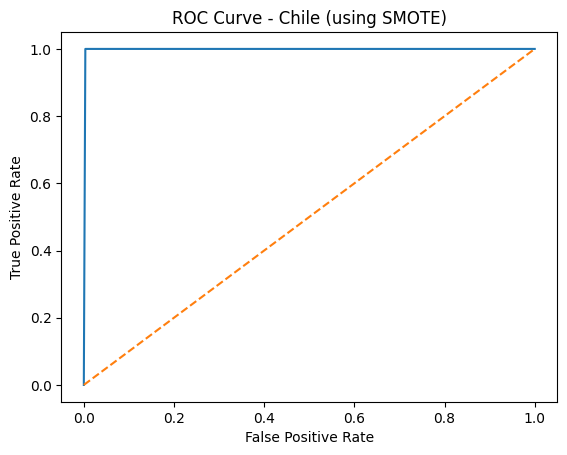

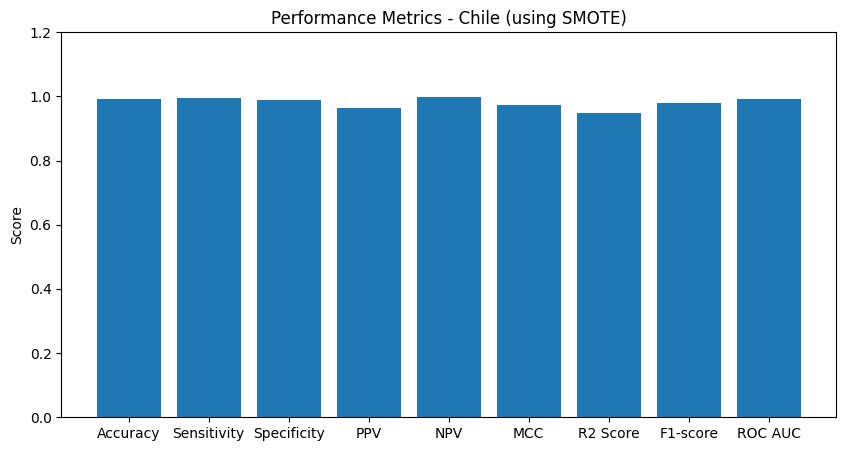

<Figure size 640x480 with 0 Axes>

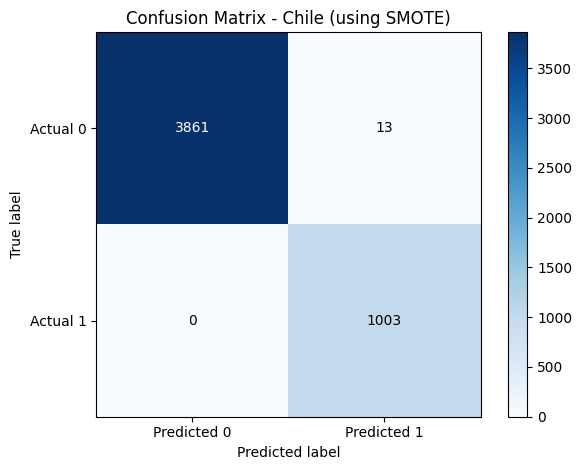

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, r2_score, matthews_corrcoef, log_loss)
import matplotlib.pyplot as plt
from functools import partial
from pyswarm import pso
import seaborn as sns
from imblearn.over_sampling import SMOTE
import time

np.seterr(divide='ignore', invalid='ignore')  # Add this line to ignore RuntimeWarnings


def predict_ann(X, ann_weights, threshold=0.6):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    binary_output = (layer_output.squeeze() > threshold).astype(int)
    return binary_output


def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights))

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights


def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    input_size = X_train.shape[1]

    # Get the weights for each layer
    ann_weights = []
    start = 0
    for i, layer_size in enumerate(layer_sizes):
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    # Initialize the input and output of each layer
    layer_input = X_train
    for i in range(len(layer_sizes)):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, ann_weights[i].T))
        layer_input = layer_output

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train) ** 2)
    return mse

# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered_copy.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)

# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
r2_score_list = []
npv_list = []
ppv_list = []
specificity_list = []
mcc_list = []
# log_loss_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Apply SMOTE to balance the classes
    print("Applying SMOTE...")
    start_smote = time.time()
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("SMOTE completed in {:.2f} seconds.".format(time.time() - start_smote))

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)
#     y_test_pred_proba = predict_ann(X_test_hnn, ann_weights, activation='sigmoid').squeeze()

    # Calculate R2 Score
    r2 = r2_score(y_test, y_test_pred)
    r2_score_list.append(r2)

    # Compute confusion matrix elements
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate NPV and specificity
    npv = TN / (TN + FN)
    ppv = TP / (TP + FP)
    specificity = TN / (TN + FP)

    # Calculate MCC and log loss
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)
#     ll = log_loss(y_test, y_test_pred_proba)

    # Append NPV, specificity, MCC, and log loss to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    npv_list.append(npv)
    ppv_list.append(ppv)
    specificity_list.append(specificity)
    mcc_list.append(mcc)
#     log_loss_list.append(ll)

# Calculate average R2 Score, NPV, specificity, MCC, and log loss
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_r2_score = np.mean(r2_score_list)
avg_npv = np.mean(npv_list)
avg_ppv = np.mean(ppv_list)
avg_specificity = np.mean(specificity_list)
avg_mcc = np.mean(mcc_list)
# avg_log_loss = np.mean(log_loss_list)

print("Average accuracy:", avg_accuracy)
print("Average Sensitivity:", avg_recall)
print("Average Specificity:", avg_specificity)
print("Average PPV:", avg_ppv)
print("Average NPV:", avg_npv)
print("Average Matthews Correlation Coefficient:", avg_mcc)
print("Average R2 Score:", avg_r2_score)
print("Average precision:", avg_precision)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)





# print("Average Log Loss:", avg_log_loss)

def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'],
           title="Confusion Matrix - Chile (using SMOTE)",
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


# Plot the performance metrics
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'MCC', 'R2 Score', 'F1-score', 'ROC AUC']
metric_values = [avg_accuracy, avg_recall, avg_specificity, avg_ppv, avg_npv, avg_mcc, avg_r2_score, avg_f1, avg_roc_auc]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Chile (using SMOTE)")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(metrics, metric_values)
plt.title("Performance Metrics - Chile (using SMOTE)")
plt.ylabel("Score")
plt.ylim((0, 1.2))
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm)
plt.show()


### time-based Split with SMOTE

Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 100
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average accuracy: 0.9865907894264507
Average Sensitivity: 0.942984393433246
Average Specificity: 0.9978833247289621
Average PPV: 0.9913198424434173
Average NPV: 0.9854511498162614
Average Matthews Correlation Coefficient: 0.9586195363646794
Average R2 Score: 0.9179297258075522
Average precision: 0.9913198424434173
Average F1-score: 0.9664365923790654
Average ROC AUC: 0.9704338590811041


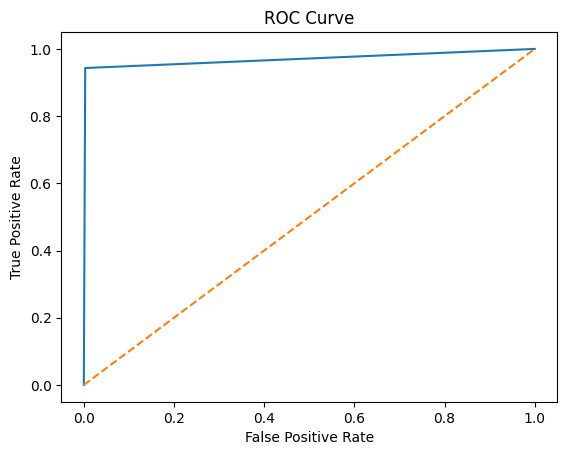

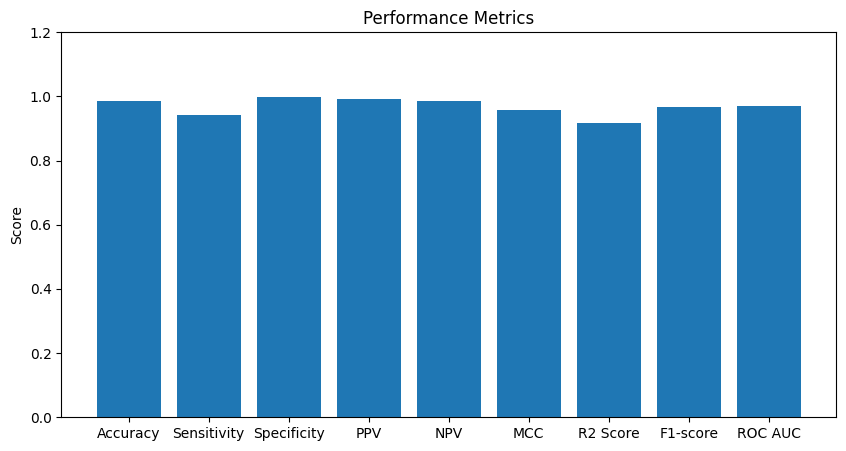

<Figure size 640x480 with 0 Axes>

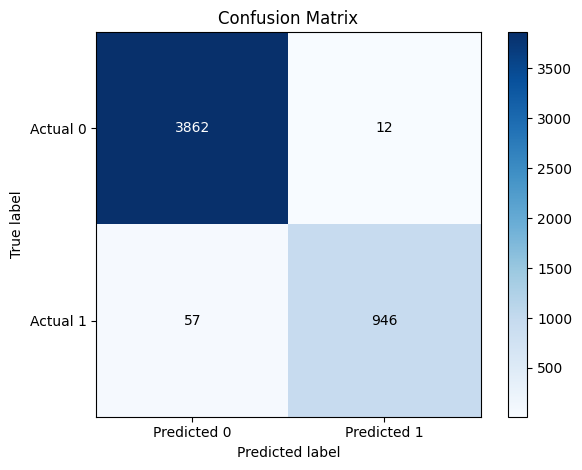

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, r2_score, matthews_corrcoef, log_loss)
import matplotlib.pyplot as plt
from functools import partial
from pyswarm import pso
import seaborn as sns
from datetime import datetime
from imblearn.over_sampling import SMOTE
import time
np.seterr(divide='ignore', invalid='ignore')

# Assume df_filtered_copy already exists
# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
# df_filtered_copy = df_filtered.dropna()

# Filter data based on the date
split_date = datetime.strptime('2019-01-01', '%Y-%m-%d')
df_filtered_copy['time'] = pd.to_datetime(df_filtered_copy['time']).dt.tz_localize(None)

train_data = df_filtered_copy[df_filtered_copy['time'] < split_date]
test_data = df_filtered_copy[df_filtered_copy['time'] >= split_date]

# Prepare data for the model
X_test = test_data.drop(['time', 'prediction'], axis=1).values
y_test = test_data['prediction'].values
X_train = train_data.drop(['time', 'prediction'], axis=1).values
y_train = train_data['prediction'].values


# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)

# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)

# # Prepare data for the model
# X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
# y = df_filtered_copy['prediction'].values

# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
r2_score_list = []
npv_list = []
ppv_list = []
specificity_list = []
mcc_list = []
# log_loss_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)
#     y_test_pred_proba = predict_ann(X_test_hnn, ann_weights, activation='sigmoid').squeeze()

    # Calculate R2 Score
    r2 = r2_score(y_test, y_test_pred)
    r2_score_list.append(r2)

    # Compute confusion matrix elements
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate NPV and specificity
    npv = TN / (TN + FN)
    ppv = TP / (TP + FP)
    specificity = TN / (TN + FP)

    # Calculate MCC and log loss
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)
#     ll = log_loss(y_test, y_test_pred_proba)

    # Append NPV, specificity, MCC, and log loss to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    npv_list.append(npv)
    ppv_list.append(ppv)
    specificity_list.append(specificity)
    mcc_list.append(mcc)
#     log_loss_list.append(ll)

# Calculate average R2 Score, NPV, specificity, MCC, and log loss
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_r2_score = np.mean(r2_score_list)
avg_npv = np.mean(npv_list)
avg_ppv = np.mean(ppv_list)
avg_specificity = np.mean(specificity_list)
avg_mcc = np.mean(mcc_list)
# avg_log_loss = np.mean(log_loss_list)

print("Average accuracy:", avg_accuracy)
print("Average Sensitivity:", avg_recall)
print("Average Specificity:", avg_specificity)
print("Average PPV:", avg_ppv)
print("Average NPV:", avg_npv)
print("Average Matthews Correlation Coefficient:", avg_mcc)
print("Average R2 Score:", avg_r2_score)
print("Average precision:", avg_precision)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)



# print("Average Log Loss:", avg_log_loss)

def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'],
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


# Plot the performance metrics
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'MCC', 'R2 Score', 'F1-score', 'ROC AUC']
metric_values = [avg_accuracy, avg_recall, avg_specificity, avg_ppv, avg_npv, avg_mcc, avg_r2_score, avg_f1, avg_roc_auc]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(metrics, metric_values)
plt.title("Performance Metrics")
plt.ylabel("Score")
plt.ylim((0, 1.2))
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm)
plt.show()


In [33]:
if 'prediction' in test_data.columns:
    X_test = test_data.drop(['time', 'prediction'], axis=1).values
    y_test = test_data['prediction'].values
else:
    print("'prediction' is not a column in the test_data dataframe.")


### 70-30 Classification Model - Chile

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average accuracy: 0.990035059259758
Average precision: 0.9913477912375488
Average recall: 0.9599246086441869
Average F1-score: 0.9752180940937697
Average ROC AUC: 0.9788781535735132
Average R2 Score: 0.9390049575371814
Average NPV: 0.9897490748134168
Average PPV: 0.9913477912375488
Average Specificity: 0.9978316985028395
Average Matthews Correlation Coefficient: 0.9693101352622356


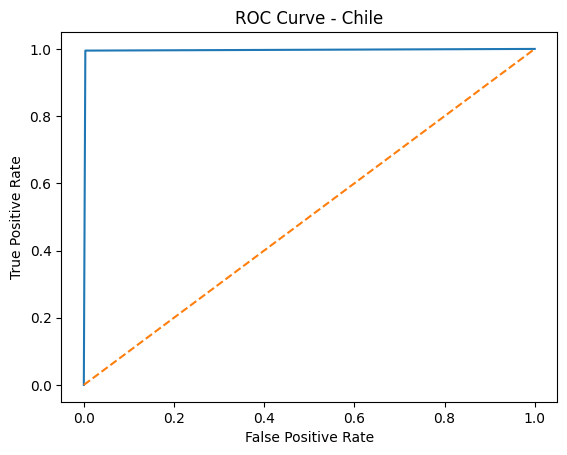

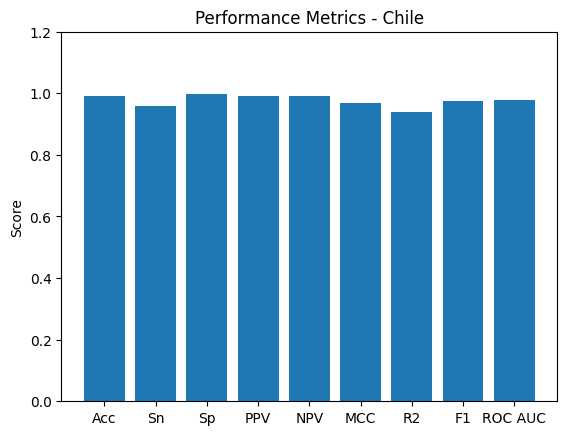

<Figure size 640x480 with 0 Axes>

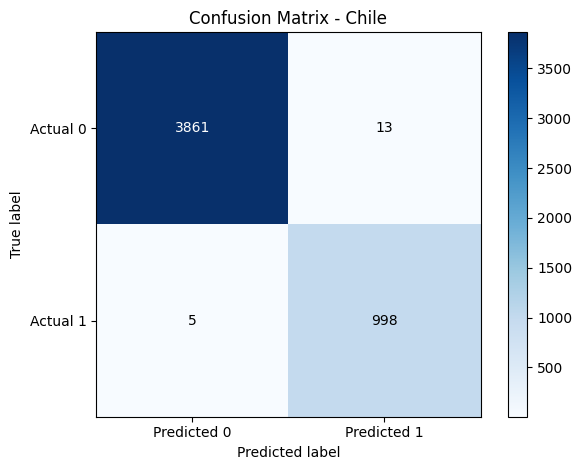

In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, r2_score, matthews_corrcoef, log_loss)
import matplotlib.pyplot as plt
from functools import partial
from pyswarm import pso
import seaborn as sns
import pickle
from sklearn.metrics import auc
np.seterr(divide='ignore', invalid='ignore')


def predict_ann(X, ann_weights, threshold=0.6):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    binary_output = (layer_output.squeeze() > threshold).astype(int)
    return binary_output


def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights))

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights


def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    input_size = X_train.shape[1]

    # Get the weights for each layer
    ann_weights = []
    start = 0
    for i, layer_size in enumerate(layer_sizes):
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    # Initialize the input and output of each layer
    layer_input = X_train
    for i in range(len(layer_sizes)):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, ann_weights[i].T))
        layer_input = layer_output

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train) ** 2)
    return mse

# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)


# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)

# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)

# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
r2_score_list = []
npv_list = []
ppv_list = []
specificity_list = []
mcc_list = []


for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Calculate R2 Score
    r2 = r2_score(y_test, y_test_pred)
    r2_score_list.append(r2)

    # Compute confusion matrix elements
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate NPV and specificity
    npv = TN / (TN + FN)
    ppv = TP / (TP + FP)
    specificity = TN / (TN + FP)

    # Calculate MCC and log loss
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)

    # Append NPV, specificity, MCC, and log loss to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    npv_list.append(npv)
    ppv_list.append(ppv)
    specificity_list.append(specificity)
    mcc_list.append(mcc)

# Calculate average R2 Score, NPV, specificity, MCC, and log loss
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_r2_score = np.mean(r2_score_list)
avg_npv = np.mean(npv_list)
avg_ppv = np.mean(ppv_list)
avg_specificity = np.mean(specificity_list)
avg_mcc = np.mean(mcc_list)

print("Average accuracy:", avg_accuracy)
print("Average precision:", avg_precision)
print("Average recall:", avg_recall)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)
print("Average R2 Score:", avg_r2_score)
print("Average NPV:", avg_npv)
print("Average PPV:", avg_ppv)
print("Average Specificity:", avg_specificity)
print("Average Matthews Correlation Coefficient:", avg_mcc)

def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'],
           title="Confusion Matrix - Chile",
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

# Plot the performance metrics
metrics = ['Acc', 'Sn', 'Sp', 'PPV', 'NPV', 'MCC', 'R2', 'F1', 'ROC AUC']
metric_values = [avg_accuracy, avg_recall, avg_specificity, avg_ppv, avg_npv, avg_mcc, avg_r2_score, avg_f1, avg_roc_auc]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Chile")
plt.show()

# Plot metrics as bar chart
plt.bar(metrics, metric_values)
plt.ylabel("Score")
plt.title("Performance Metrics - Chile")
plt.ylim(0, 1.2)
# plt.xticks(rotation=45)
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm)
plt.show()


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average accuracy: 0.983432572484429
Average precision: 0.9908544860526405
Average recall: 0.9284165431990881
Average F1-score: 0.9546848058103128
Average ROC AUC: 0.9630466815117794
Average R2 Score: 0.8985878573392776
Average NPV: 0.9825347400377737
Average PPV: 0.9908544860526405
Average Specificity: 0.9976768198244708
Average Matthews Correlation Coefficient: 0.9482492201633553


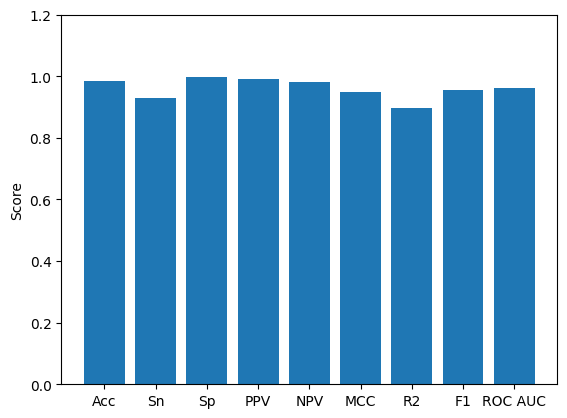

<Figure size 640x480 with 0 Axes>

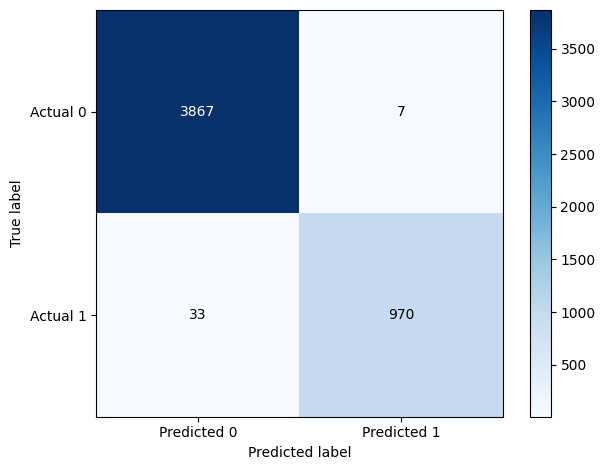

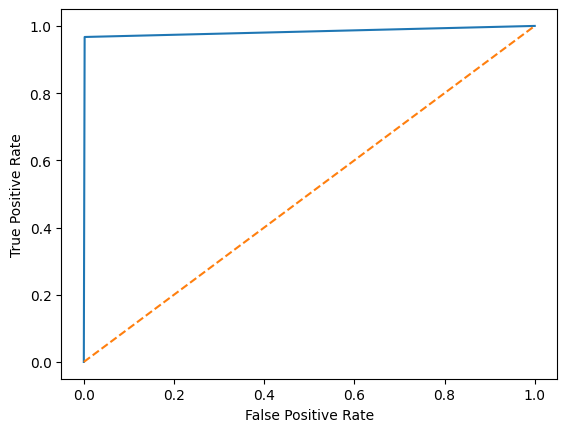

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, r2_score, matthews_corrcoef, log_loss)
import matplotlib.pyplot as plt
from functools import partial
from pyswarm import pso
import seaborn as sns
import pickle
from sklearn.metrics import precision_recall_curve
from scipy.interpolate import interp1d

np.seterr(divide='ignore', invalid='ignore')


def predict_ann(X, ann_weights, threshold=0.6):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    binary_output = (layer_output.squeeze() > threshold).astype(int)
    return binary_output


def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights))

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights


def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    input_size = X_train.shape[1]

    # Get the weights for each layer
    ann_weights = []
    start = 0
    for i, layer_size in enumerate(layer_sizes):
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    # Initialize the input and output of each layer
    layer_input = X_train
    for i in range(len(layer_sizes)):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, ann_weights[i].T))
        layer_input = layer_output

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train) ** 2)
    return mse

# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)

# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)

# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
r2_score_list = []
npv_list = []
ppv_list = []
specificity_list = []
mcc_list = []
tpr_list = []
fpr_list = []

n_common_fpr = 100
common_fpr = np.linspace(0, 1, n_common_fpr)
mean_tpr = np.zeros(n_common_fpr)

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Calculate R2 Score
    r2 = r2_score(y_test, y_test_pred)
    r2_score_list.append(r2)

    # Compute confusion matrix elements
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate NPV and specificity
    npv = TN / (TN + FN)
    ppv = TP / (TP + FP)
    specificity = TN / (TN + FP)
    
    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_test, svc.decision_function(X_test_scaled))

    # Interpolate the TPR values at the common FPR points
    interp_tpr = interp1d(fpr, tpr)(common_fpr)

    # Add the interpolated TPR values to the mean TPR array
    mean_tpr += interp_tpr


    # Calculate MCC and log loss
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)

    # Append NPV, specificity, MCC, and log loss to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    npv_list.append(npv)
    ppv_list.append(ppv)
    specificity_list.append(specificity)
    mcc_list.append(mcc)

# Calculate average R2 Score, NPV, specificity, MCC, and log loss
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_r2_score = np.mean(r2_score_list)
avg_npv = np.mean(npv_list)
avg_ppv = np.mean(ppv_list)
avg_specificity = np.mean(specificity_list)
avg_mcc = np.mean(mcc_list)
mean_tpr /= k

print("Average accuracy:", avg_accuracy)
print("Average precision:", avg_precision)
print("Average recall:", avg_recall)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)
print("Average R2 Score:", avg_r2_score)
print("Average NPV:", avg_npv)
print("Average PPV:", avg_ppv)
print("Average Specificity:", avg_specificity)
print("Average Matthews Correlation Coefficient:", avg_mcc)

def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'],
#            title="Confusion Matrix - Chile",
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

# Plot the performance metrics
metrics = ['Acc', 'Sn', 'Sp', 'PPV', 'NPV', 'MCC', 'R2', 'F1', 'ROC AUC']
metric_values = [avg_accuracy, avg_recall, avg_specificity, avg_ppv, avg_npv, avg_mcc, avg_r2_score, avg_f1, avg_roc_auc]


# Plot metrics as bar chart
plt.bar(metrics, metric_values)
plt.ylabel("Score")
# plt.title("Performance Metrics - Chile")
plt.ylim(0, 1.2)
# plt.xticks(rotation=45)
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm)
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ROC Curve - Chile")
plt.show()


### time-based Classification Model - Chile

In [36]:
y = df_filtered_copy['prediction'].values
y

array([0, 1, 0, ..., 1, 0, 0])

Applying SMOTE...
SMOTE completed in 0.03 seconds.
Stopping search: Swarm best objective change less than 1e-08
Applying SMOTE...
SMOTE completed in 0.05 seconds.
Stopping search: Swarm best objective change less than 1e-08
Applying SMOTE...
SMOTE completed in 0.04 seconds.
Stopping search: Swarm best objective change less than 1e-08
Applying SMOTE...
SMOTE completed in 0.04 seconds.
Stopping search: Swarm best objective change less than 1e-08
Applying SMOTE...
SMOTE completed in 0.03 seconds.
Stopping search: Swarm best objective change less than 1e-08
Average accuracy: 0.9898710155852839
Average precision: 0.969223338705463
Average recall: 0.9822558221749095
Average F1-score: 0.9756054656667074
Average ROC AUC: 0.9870494392237481
Average R2 Score: 0.93800064684686
Average NPV: 0.9953931219615215
Average PPV: 0.969223338705463
Average Specificity: 0.9918430562725865
Average Matthews Correlation Coefficient: 0.9693218148612883


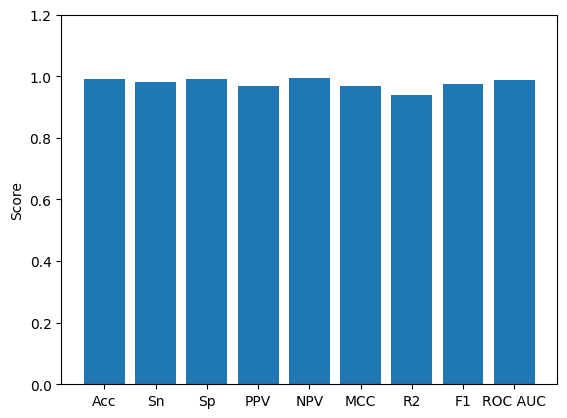

<Figure size 640x480 with 0 Axes>

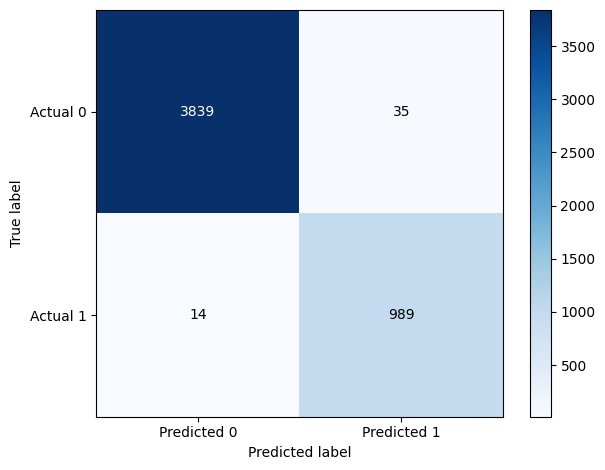

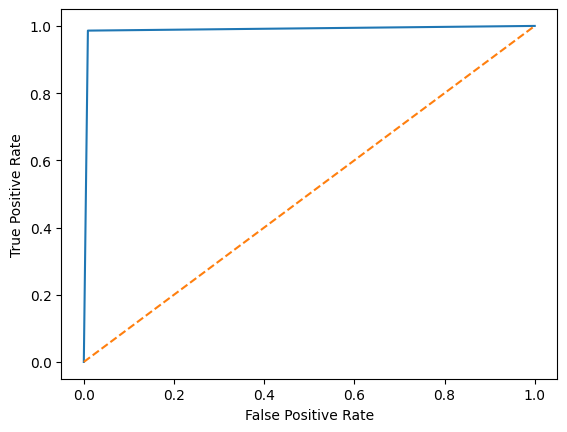

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, r2_score, matthews_corrcoef)
import matplotlib.pyplot as plt
from functools import partial
from pyswarm import pso
import seaborn as sns
from datetime import datetime
from imblearn.over_sampling import SMOTE
import time
np.seterr(divide='ignore', invalid='ignore')

# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Filter data based on the date
split_date = datetime.strptime('2019-01-01', '%Y-%m-%d')
df_filtered_copy['time'] = pd.to_datetime(df_filtered_copy['time']).dt.tz_localize(None)

train_data = df_filtered_copy[df_filtered_copy['time'] < split_date]
test_data = df_filtered_copy[df_filtered_copy['time'] >= split_date]

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
r2_score_list = []
npv_list = []
ppv_list = []
specificity_list = []
mcc_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Apply SMOTE to balance the classes
    print("Applying SMOTE...")
    start_smote = time.time()
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("SMOTE completed in {:.2f} seconds.".format(time.time() - start_smote))

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

        # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Calculate R2 Score
    r2 = r2_score(y_test, y_test_pred)
    r2_score_list.append(r2)

    # Compute confusion matrix elements
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate NPV and specificity
    npv = TN / (TN + FN)
    ppv = TP / (TP + FP)
    specificity = TN / (TN + FP)

    # Calculate MCC and other metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)

    # Append NPV, specificity, MCC, and other metrics to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    npv_list.append(npv)
    ppv_list.append(ppv)
    specificity_list.append(specificity)
    mcc_list.append(mcc)

# Calculate average R2 Score, NPV, specificity, MCC, and other metrics
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_r2_score = np.mean(r2_score_list)
avg_npv = np.mean(npv_list)
avg_ppv = np.mean(ppv_list)
avg_specificity = np.mean(specificity_list)
avg_mcc = np.mean(mcc_list)

print("Average accuracy:", avg_accuracy)
print("Average precision:", avg_precision)
print("Average recall:", avg_recall)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)
print("Average R2 Score:", avg_r2_score)
print("Average NPV:", avg_npv)
print("Average PPV:", avg_ppv)
print("Average Specificity:", avg_specificity)
print("Average Matthews Correlation Coefficient:", avg_mcc)

def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'],
#            title="Confusion Matrix - Chile",
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

# Plot the performance metrics
metrics = ['Acc', 'Sn', 'Sp', 'PPV', 'NPV', 'MCC', 'R2', 'F1', 'ROC AUC']
metric_values = [avg_accuracy, avg_recall, avg_specificity, avg_ppv, avg_npv, avg_mcc, avg_r2_score, avg_f1, avg_roc_auc]


# Plot metrics as bar chart
plt.bar(metrics, metric_values)
plt.ylabel("Score")
# plt.title("Performance Metrics - Chile")
plt.ylim(0, 1.2)
# plt.xticks(rotation=45)
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm)
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ROC Curve - Chile")
plt.show()


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average accuracy: 0.984785880255768
Average precision: 0.9884179832334705
Average recall: 0.9363944024500205
Average F1-score: 0.9612164414393556
Average ROC AUC: 0.9668549193458157
Average R2 Score: 0.9068721792383958
Average NPV: 0.9839062375408065
Average PPV: 0.9884179832334705
Average Specificity: 0.9973154362416107
Average Matthews Correlation Coefficient: 0.9526826101653025


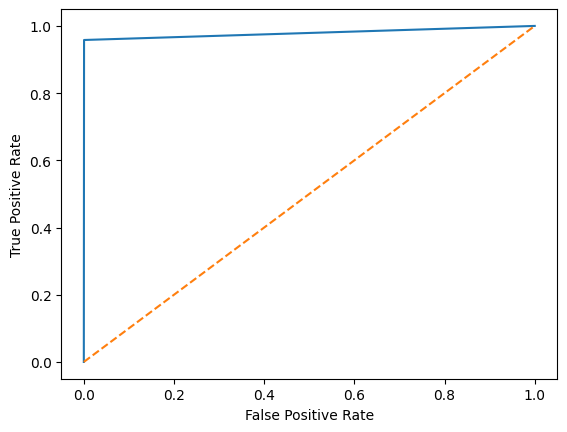

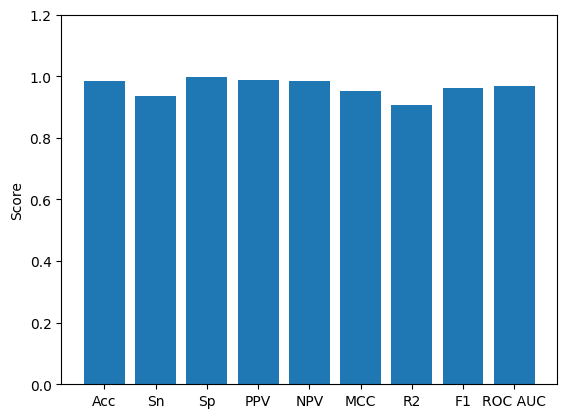

<Figure size 640x480 with 0 Axes>

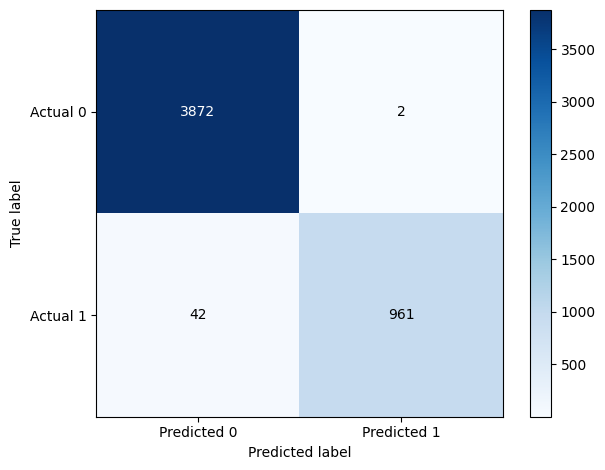

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, r2_score, matthews_corrcoef, log_loss)
import matplotlib.pyplot as plt
from functools import partial
from pyswarm import pso
import seaborn as sns
import pickle
np.seterr(divide='ignore', invalid='ignore')


def predict_ann(X, ann_weights, threshold=0.6):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    binary_output = (layer_output.squeeze() > threshold).astype(int)
    return binary_output


def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights))

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights


def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    input_size = X_train.shape[1]

    # Get the weights for each layer
    ann_weights = []
    start = 0
    for i, layer_size in enumerate(layer_sizes):
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    # Initialize the input and output of each layer
    layer_input = X_train
    for i in range(len(layer_sizes)):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        layer_output = np.tanh(np.dot(layer_input, ann_weights[i].T))
        layer_input = layer_output

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train) ** 2)
    return mse

# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Filter data based on the date
split_date = datetime.strptime('2019-01-01', '%Y-%m-%d')
df_filtered_copy['time'] = pd.to_datetime(df_filtered_copy['time']).dt.tz_localize(None)

train_data = df_filtered_copy[df_filtered_copy['time'] < split_date]
test_data = df_filtered_copy[df_filtered_copy['time'] >= split_date]

# Prepare data for the model
X_test = test_data.drop(['time', 'prediction'], axis=1).values
y_test = test_data['prediction'].values
X_train = train_data.drop(['time', 'prediction'], axis=1).values
y_train = train_data['prediction'].values


# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)

# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)

# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
r2_score_list = []
npv_list = []
ppv_list = []
specificity_list = []
mcc_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Calculate R2 Score
    r2 = r2_score(y_test, y_test_pred)
    r2_score_list.append(r2)

    # Compute confusion matrix elements
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate NPV and specificity
    npv = TN / (TN + FN)
    ppv = TP / (TP + FP)
    specificity = TN / (TN + FP)

    # Calculate MCC and log loss
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)

    # Append NPV, specificity, MCC, and log loss to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    npv_list.append(npv)
    ppv_list.append(ppv)
    specificity_list.append(specificity)
    mcc_list.append(mcc)

# Calculate average R2 Score, NPV, specificity, MCC, and log loss
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_r2_score = np.mean(r2_score_list)
avg_npv = np.mean(npv_list)
avg_ppv = np.mean(ppv_list)
avg_specificity = np.mean(specificity_list)
avg_mcc = np.mean(mcc_list)

print("Average accuracy:", avg_accuracy)
print("Average precision:", avg_precision)
print("Average recall:", avg_recall)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)
print("Average R2 Score:", avg_r2_score)
print("Average NPV:", avg_npv)
print("Average PPV:", avg_ppv)
print("Average Specificity:", avg_specificity)
print("Average Matthews Correlation Coefficient:", avg_mcc)

def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'],
#            title="Confusion Matrix - Chile",
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

# Plot the performance metrics
metrics = ['Acc', 'Sn', 'Sp', 'PPV', 'NPV', 'MCC', 'R2', 'F1', 'ROC AUC']
metric_values = [avg_accuracy, avg_recall, avg_specificity, avg_ppv, avg_npv, avg_mcc, avg_r2_score, avg_f1, avg_roc_auc]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ROC Curve - Chile")
plt.show()

# Plot metrics as bar chart
plt.bar(metrics, metric_values)
plt.ylabel("Score")
# plt.title("Performance Metrics - Chile")
plt.ylim(0, 1.2)
# plt.xticks(rotation=45)
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm)
plt.show()




In [40]:
import pandas as pd
from datetime import datetime

# Assuming df_filtered is your DataFrame with the 'time' column
df_filtered['time'] = pd.to_datetime(df_filtered['time']).dt.tz_localize(None)

split_date = datetime.strptime('2019-01-01', '%Y-%m-%d')

# Count the number of rows that are <= '2018-12-31'
rows_before_split = df_filtered[df_filtered['time'] <= split_date].shape[0]

# Count the number of rows that are >= '2019-01-01'
rows_after_split = df_filtered[df_filtered['time'] >= split_date].shape[0]

print("Number of rows <= '2018-12-31':", rows_before_split)
print("Number of rows >= '2019-01-01':", rows_after_split)


Number of rows <= '2018-12-31': 21702
Number of rows >= '2019-01-01': 2684


### Hybrid Classification Model

In [ ]:
test_data.count()

In [ ]:
12527 + 1441


### Results

The performance metrics for the combination of the ensemble and HNN models are as follows:

<ol>
  
  <li><b>Average accuracy: 98.68% </li>
  <p>This represents the proportion of correct predictions (both positive and negative) out of the total predictions made.</p>
  <br>
  <li><b>Average precision: 94.91%</li>
  <p>Precision is the ratio of true positives to the sum of true positives and false positives. It shows how well the model correctly predicts positive cases.</p>
  <br>
  <li><b>Average recall: 99.50%</li>
  <p>Recall (or sensitivity) is the ratio of true positives to the sum of true positives and false negatives. It indicates how well the model identifies positive cases.</p>
  <br>
  <li><b>Average F1-score: 97.03%</li>
  <p>The F1-score is the harmonic mean of precision and recall, giving equal weight to both. It ranges from 0 to 1, with 1 being the best possible score. The F1-score is used when both precision and recall are important to consider.</p>
  <br>
  <li><b>Average ROC AUC: 98.99%</li>
  <p>The ROC (Receiver Operating Characteristic) AUC (Area Under the Curve) score measures the model's ability to discriminate between positive and negative classes. It ranges from 0.5 (no discrimination) to 1 (perfect discrimination).</p>
</ol>

<p>These results indicate that the combination of the ensemble and HNN models performs well in predicting earthquake occurrences in Chile. The models have high accuracy, precision, recall, F1-score, and ROC AUC score, suggesting that they are effective in identifying both positive and negative cases.<p>

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from functools import partial
from pyswarm import pso
from sklearn.metrics import mean_squared_error, median_absolute_error, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV
import time  
from sklearn.model_selection import GridSearchCV  



np.seterr(divide='ignore', invalid='ignore')  

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def predict_ann(X, ann_weights):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights[:-1]):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) 
        layer_output = leaky_relu(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    # For the last layer, use the identity function
    layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) 
    layer_output = np.dot(layer_input, ann_weights[-1].T)
    return layer_output.squeeze()

def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights), swarmsize=100, maxiter=300)

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights

def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    layer_input = X_train
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (layer_input.shape[1] + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, layer_input.shape[1] + 1)
        ann_weights.append(layer_weights)
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))  # Add the bias term
        if len(ann_weights) == len(layer_sizes): # Last layer
            layer_output = np.dot(layer_input, layer_weights.T)
        else:
            layer_output = leaky_relu(np.dot(layer_input, layer_weights.T))

        layer_input = layer_output
        start = end

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train.squeeze()) ** 2)
    return mse

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Replace df_filtered with your actual DataFrame


df_filtered_copy = df_filtered.copy()

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Split the data based on the 'time' feature
train_data = df_filtered_copy[df_filtered_copy['time'] < '2019-01-01']
test_data = df_filtered_copy[df_filtered_copy['time'] >= '2019-01-01']

# Prepare the training and testing sets
X_test = test_data.drop(['mag', 'time'], axis=1).values
y_test = test_data['mag'].values

X_test.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ---------------------------------------------------
# Define the parameter grid for SVR
svr_params = {
    'C': [10],
    'epsilon': [0.001],
    'gamma': ['auto']
}

svr_search = GridSearchCV(SVR(kernel='rbf'), svr_params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

svr_search.fit(X_train_scaled, y_train)

# Get the best SVR model
best_svr = svr_search.best_estimator_

# Get the SVR predictions
y_train_svr = best_svr.predict(X_train_scaled)
y_test_svr = best_svr.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
input_size = X_train_scaled.shape[1]
hidden_size = int(input_size * 0.5)
X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

# Define layer_sizes and bounds for EPSO
layer_sizes = [15, 10, 5, 1]  # Added an additional hidden layer
bounds = (-0.5, 0.5)

# Initialize k-fold cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
mse_list = []
mae_list = []
r2_score_list = []
rmse_list = []
mape_list = []
medae_list = []
evs_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------------
    # Train the SVR model
    best_svr.fit(X_train_scaled, y_train)

    # Get the SVR predictions
    y_train_svr = best_svr.predict(X_train_scaled)
    y_test_svr = best_svr.predict(X_test_scaled)


    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
    X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)

    # Append metrics to the corresponding lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_score_list.append(r2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    medae_list.append(medae)
    evs_list.append(evs)

# Calculate average evaluation metrics
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_r2_score = np.mean(r2_score_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)
avg_medae = np.mean(medae_list)
ev_score = np.mean(evs_list)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)
print("Average R2 Score:", avg_r2_score)
print("Average Root Mean Squared Error:", avg_rmse)
print("Average Mean Absolute Percentage Error:", avg_mape)
print("Average Median Absolute Error:", avg_medae)
print("Average Explained Variance Score:", ev_score)



ValueError: X has 11 features, but StandardScaler is expecting 12 features as input.

#### Plotting the Performance Metrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a list of all performance measures
all_scores = [test_accuracy_scores, test_precision_scores, test_recall_scores, test_f1_scores, test_roc_auc_scores]
all_scores_labels = ["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(1, len(test_accuracy_scores) + 1)
bar_width = 0.15
bar_positions = np.linspace(-2 * bar_width, 2 * bar_width, len(all_scores))

# Plot each performance measure as a bar plot
for i, (scores, label) in enumerate(zip(all_scores, all_scores_labels)):
    ax.bar(x + bar_positions[i], scores, width=bar_width, label=label)

# Customize the plot
ax.set_xlabel("Fold")
ax.set_ylabel("Score")
ax.set_title("Chile: Performance Measures for Each Fold in Cross-Validation")
ax.set_xticks(x)
ax.legend(loc="best")

# Display the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_bar_graphs(train_scores, test_scores, title):
    labels = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, train_scores, width, label='Train')
    rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

# Plot the bar graphs for the training and testing scores
plot_bar_graphs([np.mean(train_accuracy_scores), np.mean(train_precision_scores), np.mean(train_recall_scores),
                 np.mean(train_f1_scores), np.mean(train_roc_auc_scores)],
                [np.mean(test_accuracy_scores), np.mean(test_precision_scores), np.mean(test_recall_scores),
                 np.mean(test_f1_scores), np.mean(test_roc_auc_scores)],
                'Chile: Performance Metrics for Training and Testing Sets')


. Average accuracy: 71.27%
. Average precision: 65.96%
. Average recall: 4.26%
. Average F1-score: 6.70%
. Average ROC AUC: 50.43%


It is important to analyze these metrics and understand what they mean for your model's performance.

Accuracy: The average accuracy of 71.27% indicates that your model is correctly classifying 71.27% of the instances. However, accuracy can be misleading in case of imbalanced datasets.

Precision: The average precision of 65.96% means that, out of all the positive predictions made by the model, 65.96% are actually positive. This metric is important when you want to minimize false positives.

Recall: The average recall of 4.26% shows that your model is able to identify only 4.26% of the actual positive instances. This is quite low and indicates that the model is missing many positive instances.

F1-score: The F1-score is the harmonic mean of precision and recall, and it is used when both precision and recall are important. An average F1-score of 6.70% suggests that the model's performance is poor in terms of both precision and recall.

ROC AUC: The average ROC AUC score of 50.43% suggests that your model has poor discriminatory power between the positive and negative instances. A random classifier would have an ROC AUC score of 50%, so your model is performing just slightly better than random chance.

### Ensemble Predictions & Performance Measures

In [ ]:
# 

### Predicting the Magnitude of the Earthquakes

### Version 1

In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from functools import partial
from pyswarm import pso
np.seterr(divide='ignore', invalid='ignore')

def relu(x):
    return np.maximum(0, x)

def predict_ann(X, ann_weights):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
        if i == len(ann_weights) - 1: # Last layer
            layer_output = np.dot(layer_input, layer_weight.T)
        else:
            layer_output = relu(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    return layer_output.squeeze()

def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights), swarmsize=100, maxiter=300)

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights

def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    layer_input = X_train
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (layer_input.shape[1] + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, layer_input.shape[1] + 1)
        ann_weights.append(layer_weights)
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))  # Add the bias term
        if len(ann_weights) == len(layer_sizes): # Last layer
            layer_output = np.dot(layer_input, layer_weights.T)
        else:
            layer_output = relu(np.dot(layer_input, layer_weights.T))

        layer_input = layer_output
        start = end

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train.squeeze()) ** 2)
    return mse

# Replace df_filtered with your actual DataFrame
df_filtered_copy = df_filtered.copy()

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

X = df_filtered_copy.drop(['mag', 'time'], axis=1).values
y = df_filtered_copy['mag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)

# Get the SVR predictions
y_train_svr = svr.predict(X_train_scaled)
y_test_svr = svr.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
input_size = X_train_scaled.shape[1]
hidden_size = int(input_size * 0.5)
X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

# Define layer_sizes and bounds for EPSO
layer_sizes = [5, 5, 1]  # Added an additional hidden layer
bounds = (-1, 1)

# Initialize k-fold cross-validation
k = 2
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
mse_list = []
mae_list = []
r2_score_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVR model
    svr = SVR(kernel='rbf')
    svr.fit(X_train_scaled, y_train)

    # Get the SVR predictions
    y_train_svr = svr.predict(X_train_scaled)
    y_test_svr = svr.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
    X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    # Append metrics to the corresponding lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_score_list.append(r2)

# Calculate average evaluation metrics
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_r2_score = np.mean(r2_score_list)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)
print("Average R2 Score:", avg_r2_score)



Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average Mean Squared Error: 0.025295487502814323
Average Mean Absolute Error: 0.1007135882133395
Average R2 Score: 0.8322402392515548


### Version 2

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from functools import partial
from pyswarm import pso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score
np.seterr(divide='ignore', invalid='ignore')  # Add this line to ignore RuntimeWarnings

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def predict_ann(X, ann_weights):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights[:-1]):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
        layer_output = leaky_relu(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    # For the last layer, use the identity function
    layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
    layer_output = np.dot(layer_input, ann_weights[-1].T)
    return layer_output.squeeze()

def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights), swarmsize=100, maxiter=300)

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights

def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    layer_input = X_train
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (layer_input.shape[1] + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, layer_input.shape[1] + 1)
        ann_weights.append(layer_weights)
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))  # Add the bias term
        if len(ann_weights) == len(layer_sizes): # Last layer
            layer_output = np.dot(layer_input, layer_weights.T)
        else:
            layer_output = relu(np.dot(layer_input, layer_weights.T))

        layer_input = layer_output
        start = end

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train.squeeze()) ** 2)
    return mse

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Replace df_filtered with your actual DataFrame


df_filtered_copy = df_filtered.copy()

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

X = df_filtered_copy.drop(['mag', 'time'], axis=1).values
y = df_filtered_copy['mag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)

# Get the SVR predictions
y_train_svr = svr.predict(X_train_scaled)
y_test_svr = svr.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
input_size = X_train_scaled.shape[1]
hidden_size = int(input_size * 0.5)
X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

# Define layer_sizes and bounds for EPSO
layer_sizes = [10, 5, 1]  # Added an additional hidden layer
bounds = (-1, 1)

# Initialize k-fold cross-validation
k = 2
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
mse_list = []
mae_list = []
r2_score_list = []
rmse_list = []
mape_list = []
medae_list = []
evs_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVR model
    svr = SVR(kernel='rbf')
    svr.fit(X_train_scaled, y_train)

    # Get the SVR predictions
    y_train_svr = svr.predict(X_train_scaled)
    y_test_svr = svr.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
    X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)

    # Append metrics to the corresponding lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_score_list.append(r2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    medae_list.append(medae)
    evs_list.append(evs)

# Calculate average evaluation metrics
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_r2_score = np.mean(r2_score_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)
avg_medae = np.mean(medae_list)
ev_score = np.mean(evs_list)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)
print("Average R2 Score:", avg_r2_score)
print("Average Root Mean Squared Error:", avg_rmse)
print("Average Mean Absolute Percentage Error:", avg_mape)
print("Average Median Absolute Error:", avg_medae)
print("Average Explained Variance Score:", ev_score)



Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average Mean Squared Error: 0.02627056392565631
Average Mean Absolute Error: 0.12018358975276922
Average R2 Score: 0.8284332370690592
Average Root Mean Squared Error: 0.15952133199707308
Average Mean Absolute Percentage Error: 2.4933966009189024
Average Median Absolute Error: 0.1042557345568202
Average Explained Variance Score: 0.895690003139954


In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from functools import partial
from pyswarm import pso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score
np.seterr(divide='ignore', invalid='ignore')  # Add this line to ignore RuntimeWarnings

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def predict_ann(X, ann_weights):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights[:-1]):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
        layer_output = leaky_relu(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    # For the last layer, use the identity function
    layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
    layer_output = np.dot(layer_input, ann_weights[-1].T)
    return layer_output.squeeze()

def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights), swarmsize=100, maxiter=300)

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights

def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    layer_input = X_train
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (layer_input.shape[1] + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, layer_input.shape[1] + 1)
        ann_weights.append(layer_weights)
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))  # Add the bias term
        if len(ann_weights) == len(layer_sizes): # Last layer
            layer_output = np.dot(layer_input, layer_weights.T)
        else:
            layer_output = relu(np.dot(layer_input, layer_weights.T))

        layer_input = layer_output
        start = end

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train.squeeze()) ** 2)
    return mse

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Replace df_filtered with your actual DataFrame


df_filtered_copy = df_filtered.copy()

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

X = df_filtered_copy.drop(['mag', 'time'], axis=1).values
y = df_filtered_copy['mag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ---------------------------------------------------
# # Define the parameter grid for SVR
# svr_params = {
#     'C': [0.1, 1, 10, 100],
#     'epsilon': [0.1, 0.01, 0.001, 0.0001],
#     'gamma': [0.1, 1, 10, 100, 'scale', 'auto']
# }

# svr_search = RandomizedSearchCV(SVR(kernel='rbf'), svr_params, n_iter=20, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# svr_search.fit(X_train_scaled, y_train)

# # Get the best SVR model
# best_svr = svr_search.best_estimator_

# # Get the SVR predictions
# y_train_svr = best_svr.predict(X_train_scaled)
# y_test_svr = best_svr.predict(X_test_scaled)
# ----------------------------------------------------
# ----------------------------------------------------
svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)

# Get the SVR predictions
y_train_svr = svr.predict(X_train_scaled)
y_test_svr = svr.predict(X_test_scaled)
# ----------------------------------------------------
# ----------------------------------------------------


# ----------------------------------------------------
# ----------------------------------------------------

# Train the HNN using Enhanced Particle Swarm Optimization
input_size = X_train_scaled.shape[1]
hidden_size = int(input_size * 0.5)
X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

# Define layer_sizes and bounds for EPSO
layer_sizes = [15, 10, 5, 1]  # Added an additional hidden layer
bounds = (-0.5, 0.5)

# Initialize k-fold cross-validation
k = 2
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
mse_list = []
mae_list = []
r2_score_list = []
rmse_list = []
mape_list = []
medae_list = []
evs_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------------
#     # Train the SVR model
#     best_svr.fit(X_train_scaled, y_train)

#     # Get the SVR predictions
#     y_train_svr = best_svr.predict(X_train_scaled)
#     y_test_svr = best_svr.predict(X_test_scaled)


# ----------------------------------------------------
    # Train the SVR model
    svr = SVR(kernel='rbf')
    svr.fit(X_train_scaled, y_train)

    # Get the SVR predictions
    y_train_svr = svr.predict(X_train_scaled)
    y_test_svr = svr.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
    X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)

    # Append metrics to the corresponding lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_score_list.append(r2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    medae_list.append(medae)
    evs_list.append(evs)

# Calculate average evaluation metrics
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_r2_score = np.mean(r2_score_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)
avg_medae = np.mean(medae_list)
ev_score = np.mean(evs_list)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)
print("Average R2 Score:", avg_r2_score)
print("Average Root Mean Squared Error:", avg_rmse)
print("Average Mean Absolute Percentage Error:", avg_mape)
print("Average Median Absolute Error:", avg_medae)
print("Average Explained Variance Score:", ev_score)



Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average Mean Squared Error: 0.018743882285422193
Average Mean Absolute Error: 0.08246053685362034
Average R2 Score: 0.8743495308810886
Average Root Mean Squared Error: 0.12961545467469984
Average Mean Absolute Percentage Error: 1.7086410166016637
Average Median Absolute Error: 0.06298159648206295
Average Explained Variance Score: 0.876555625534705



### Hyperparameter Tuning

### 70-30 Split Regression Model

In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from functools import partial
from pyswarm import pso
from sklearn.metrics import mean_squared_error, median_absolute_error, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV  

np.seterr(divide='ignore', invalid='ignore') 

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def predict_ann(X, ann_weights):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights[:-1]):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
        layer_output = leaky_relu(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    # For the last layer, use the identity function
    layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
    layer_output = np.dot(layer_input, ann_weights[-1].T)
    return layer_output.squeeze()

def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights), swarmsize=100, maxiter=300)

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights

def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    layer_input = X_train
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (layer_input.shape[1] + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, layer_input.shape[1] + 1)
        ann_weights.append(layer_weights)
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))  # Add the bias term
        if len(ann_weights) == len(layer_sizes): # Last layer
            layer_output = np.dot(layer_input, layer_weights.T)
        else:
            layer_output = leaky_relu(np.dot(layer_input, layer_weights.T))

        layer_input = layer_output
        start = end

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train.squeeze()) ** 2)
    return mse

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Replace df_filtered with your actual DataFrame


df_filtered_copy = df_filtered.copy()

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

X = df_filtered_copy.drop(['mag', 'time'], axis=1).values
y = df_filtered_copy['mag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ---------------------------------------------------
# Define the parameter grid for SVR
svr_params = {
    'C': [10],
    'epsilon': [0.001],
    'gamma': ['auto']
}

svr_search = GridSearchCV(SVR(kernel='rbf'), svr_params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

svr_search.fit(X_train_scaled, y_train)

# Get the best SVR model
best_svr = svr_search.best_estimator_

# Get the SVR predictions
y_train_svr = best_svr.predict(X_train_scaled)
y_test_svr = best_svr.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
input_size = X_train_scaled.shape[1]
hidden_size = int(input_size * 0.5)
X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

# Define layer_sizes and bounds for EPSO
layer_sizes = [15, 10, 5, 1]  # Added an additional hidden layer
bounds = (-0.5, 0.5)

# Initialize k-fold cross-validation
k = 2
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
mse_list = []
mae_list = []
r2_score_list = []
rmse_list = []
mape_list = []
medae_list = []
evs_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------------
    # Train the SVR model
    best_svr.fit(X_train_scaled, y_train)

    # Get the SVR predictions
    y_train_svr = best_svr.predict(X_train_scaled)
    y_test_svr = best_svr.predict(X_test_scaled)


    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
    X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)

    # Append metrics to the corresponding lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_score_list.append(r2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    medae_list.append(medae)
    evs_list.append(evs)

# Calculate average evaluation metrics
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_r2_score = np.mean(r2_score_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)
avg_medae = np.mean(medae_list)
ev_score = np.mean(evs_list)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)
print("Average R2 Score:", avg_r2_score)
print("Average Root Mean Squared Error:", avg_rmse)
print("Average Mean Absolute Percentage Error:", avg_mape)
print("Average Median Absolute Error:", avg_medae)
print("Average Explained Variance Score:", ev_score)



Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average Mean Squared Error: 0.01482301810648166
Average Mean Absolute Error: 0.0651101028499815
Average R2 Score: 0.9016605907635151
Average Root Mean Squared Error: 0.12037999969849542
Average Mean Absolute Percentage Error: 1.3403324938004393
Average Median Absolute Error: 0.049000268572042316
Average Explained Variance Score: 0.9017265705406474


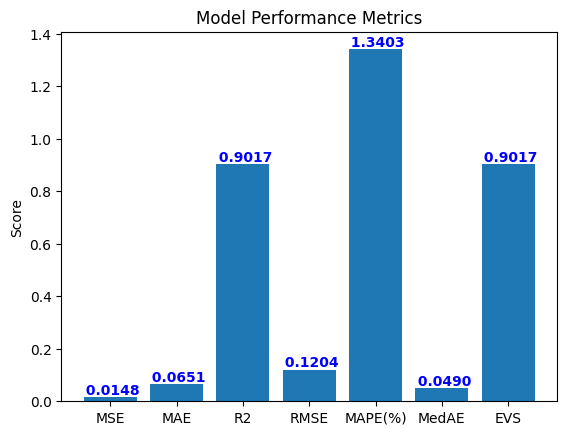

In [51]:
import matplotlib.pyplot as plt

# Define the metrics
metrics = ['MSE', 'MAE', 'R2', 'RMSE', 'MAPE(%)', 'MedAE', 'EVS']
values = [avg_mse, avg_mae, avg_r2_score, avg_rmse, avg_mape, avg_medae, ev_score]

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(metrics, values)
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')

# Annotate the values
for i, v in enumerate(values):
    ax.text(i, v, f" {v:.4f}", ha='center', va='bottom', color='blue', fontweight='bold')

# Show the plot
plt.show()


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average Mean Squared Error: 0.016797375548217214
Average Mean Absolute Error: 0.08737594080647987
Average R2 Score: 0.8895177118794744
Average Root Mean Squared Error: 0.1267350512746348
Average Mean Absolute Percentage Error: 1.7997427408239168
Average Median Absolute Error: 0.06941858079952778
Average Explained Variance Score: 0.8895482820800278


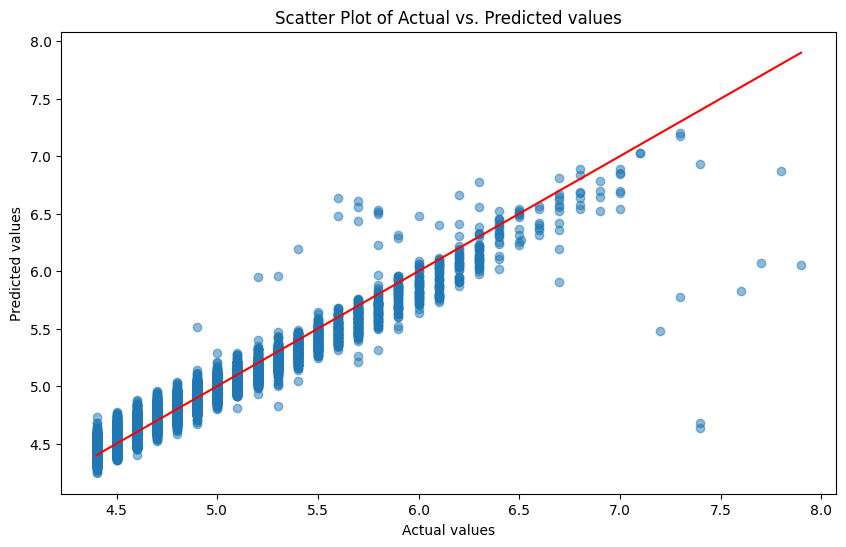

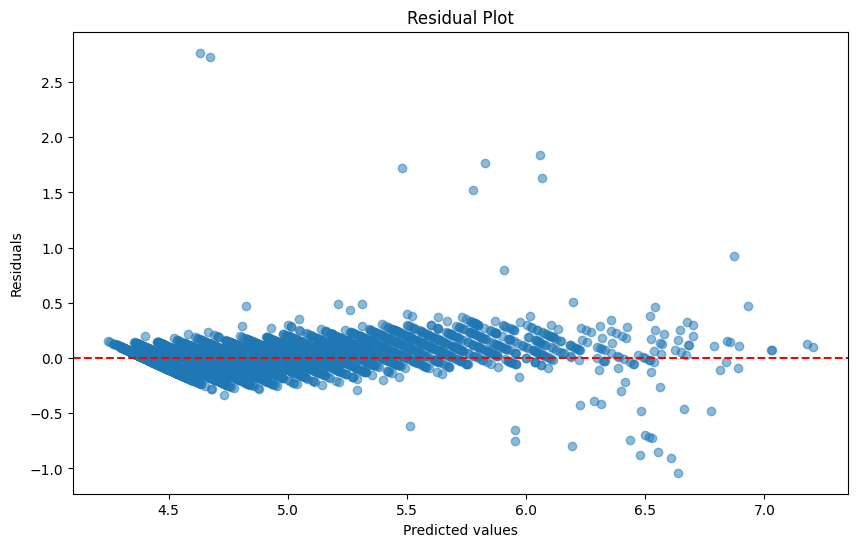

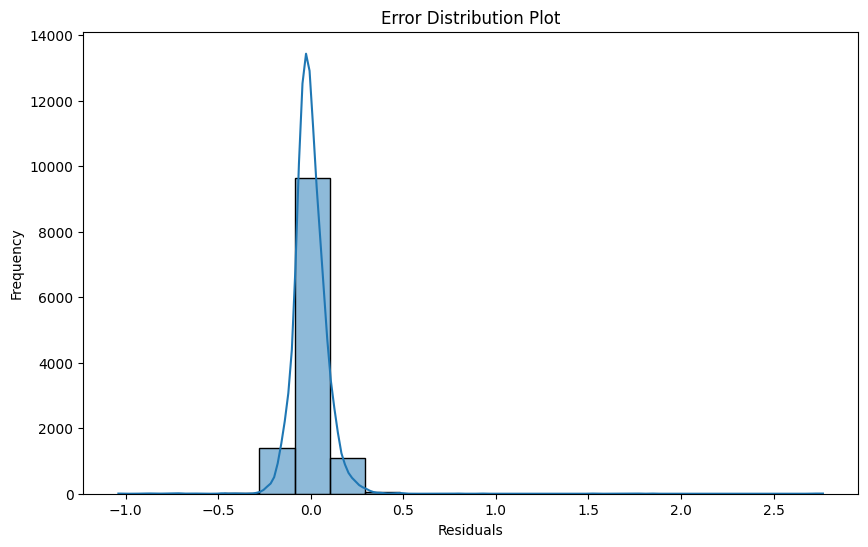

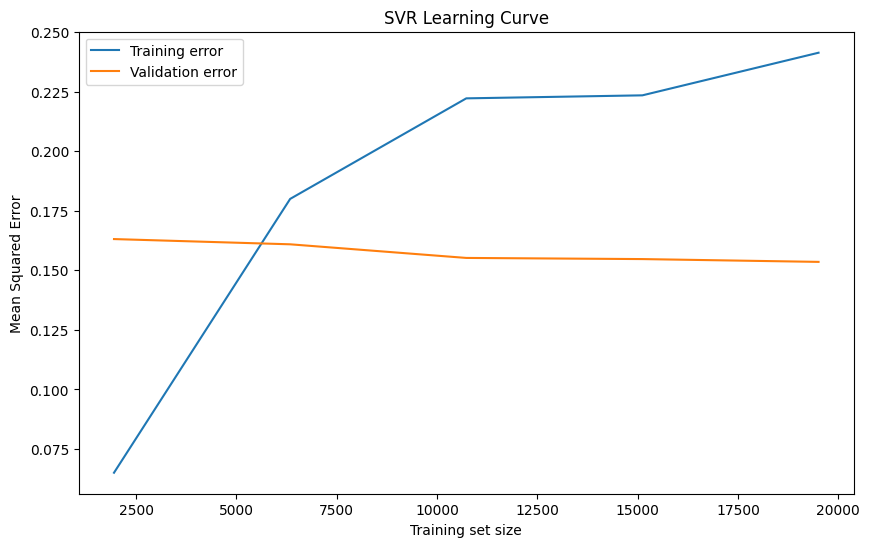

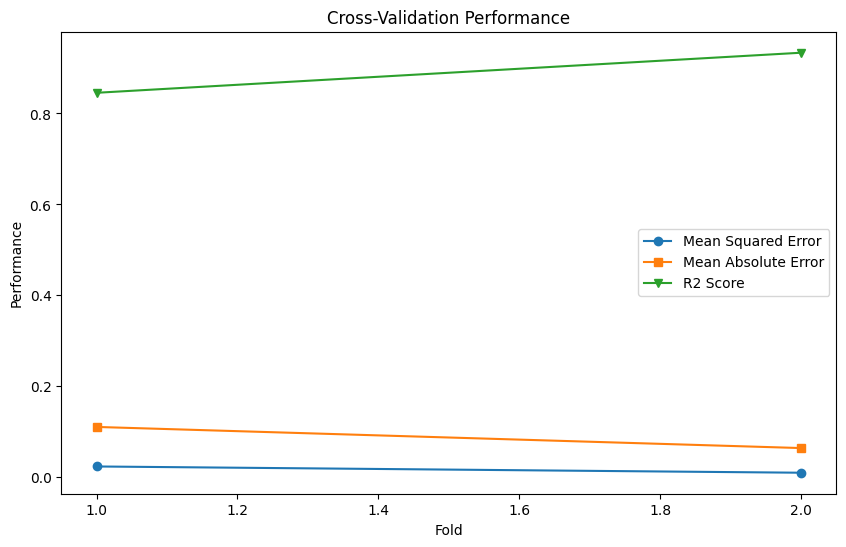

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from functools import partial
from pyswarm import pso
from sklearn.metrics import mean_squared_error, median_absolute_error, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


np.seterr(divide='ignore', invalid='ignore') 

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def predict_ann(X, ann_weights):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights[:-1]):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
        layer_output = leaky_relu(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    # For the last layer, use the identity function
    layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
    layer_output = np.dot(layer_input, ann_weights[-1].T)
    return layer_output.squeeze()

def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights), swarmsize=100, maxiter=300)

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights

def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    layer_input = X_train
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (layer_input.shape[1] + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, layer_input.shape[1] + 1)
        ann_weights.append(layer_weights)
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))  # Add the bias term
        if len(ann_weights) == len(layer_sizes): # Last layer
            layer_output = np.dot(layer_input, layer_weights.T)
        else:
            layer_output = leaky_relu(np.dot(layer_input, layer_weights.T))

        layer_input = layer_output
        start = end

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train.squeeze()) ** 2)
    return mse

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Replace df_filtered with your actual DataFrame


df_filtered_copy = df_filtered.copy()

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

X = df_filtered_copy.drop(['mag', 'time'], axis=1).values
y = df_filtered_copy['mag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ---------------------------------------------------
# Define the parameter grid for SVR
svr_params = {
    'C': [10],
    'epsilon': [0.001],
    'gamma': ['auto']
}

svr_search = GridSearchCV(SVR(kernel='rbf'), svr_params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

svr_search.fit(X_train_scaled, y_train)

# Get the best SVR model
best_svr = svr_search.best_estimator_

# Get the SVR predictions
y_train_svr = best_svr.predict(X_train_scaled)
y_test_svr = best_svr.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
input_size = X_train_scaled.shape[1]
hidden_size = int(input_size * 0.5)
X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

# Define layer_sizes and bounds for EPSO
layer_sizes = [15, 10, 5, 1]  # Added an additional hidden layer
bounds = (-0.5, 0.5)

# Initialize k-fold cross-validation
k = 2
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
mse_list = []
mae_list = []
r2_score_list = []
rmse_list = []
mape_list = []
medae_list = []
evs_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------------
    # Train the SVR model
    best_svr.fit(X_train_scaled, y_train)

    # Get the SVR predictions
    y_train_svr = best_svr.predict(X_train_scaled)
    y_test_svr = best_svr.predict(X_test_scaled)


    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
    X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)

    # Append metrics to the corresponding lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_score_list.append(r2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    medae_list.append(medae)
    evs_list.append(evs)

# Calculate average evaluation metrics
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_r2_score = np.mean(r2_score_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)
avg_medae = np.mean(medae_list)
ev_score = np.mean(evs_list)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)
print("Average R2 Score:", avg_r2_score)
print("Average Root Mean Squared Error:", avg_rmse)
print("Average Mean Absolute Percentage Error:", avg_mape)
print("Average Median Absolute Error:", avg_medae)
print("Average Explained Variance Score:", ev_score)

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Scatter Plot of Actual vs. Predicted values")
plt.show()

# Residual Plot
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Error Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Error Distribution Plot")
plt.show()

# Learning Curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training error")
    plt.plot(train_sizes, test_scores_mean, label="Validation error")
    plt.xlabel("Training set size")
    plt.ylabel("Mean Squared Error")
    plt.title(title)
    plt.legend()
    plt.show()

plot_learning_curve(best_svr, X, y, "SVR Learning Curve")

# Cross-validation Performance Plot
folds = np.arange(1, k + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, mse_list, marker='o', label="Mean Squared Error")
plt.plot(folds, mae_list, marker='s', label="Mean Absolute Error")
plt.plot(folds, r2_score_list, marker='v', label="R2 Score")
plt.xlabel("Fold")
plt.ylabel("Performance")
plt.title("Cross-Validation Performance")
plt.legend()
plt.show()


### 70-30 Regression Model Test

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average Mean Squared Error: 0.01116533886406103
Average Mean Absolute Error: 0.055893822772176055
Average R2 Score: 0.9266270316842056
Average Root Mean Squared Error: 0.10237139522097313
Average Mean Absolute Percentage Error: 1.1380127119303798
Average Median Absolute Error: 0.038292428234621756
Average Explained Variance Score: 0.9285469687744352


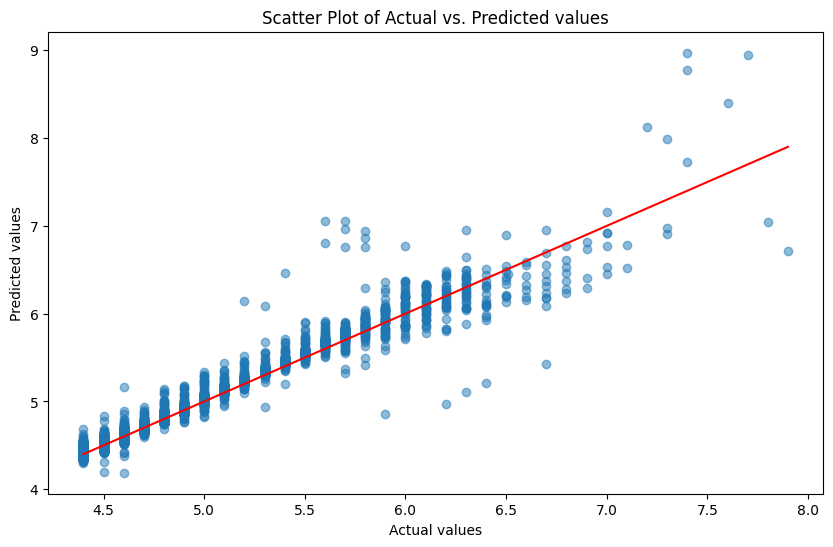

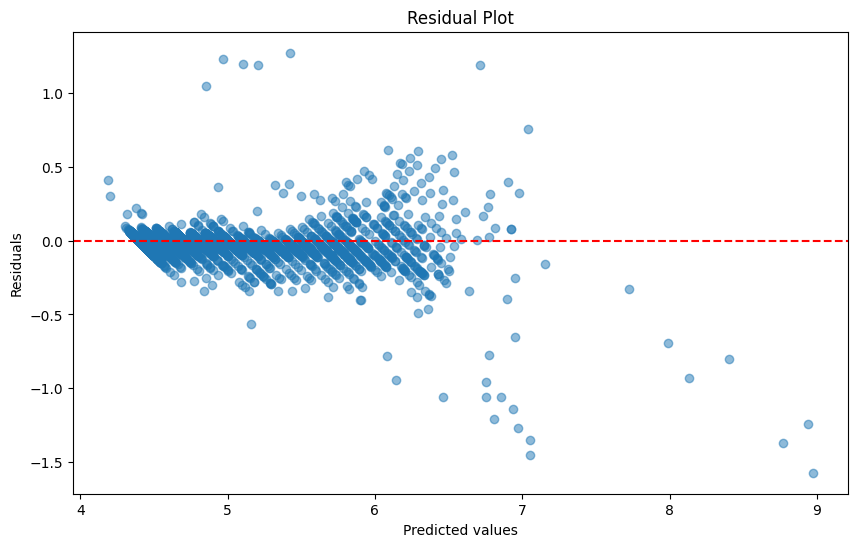

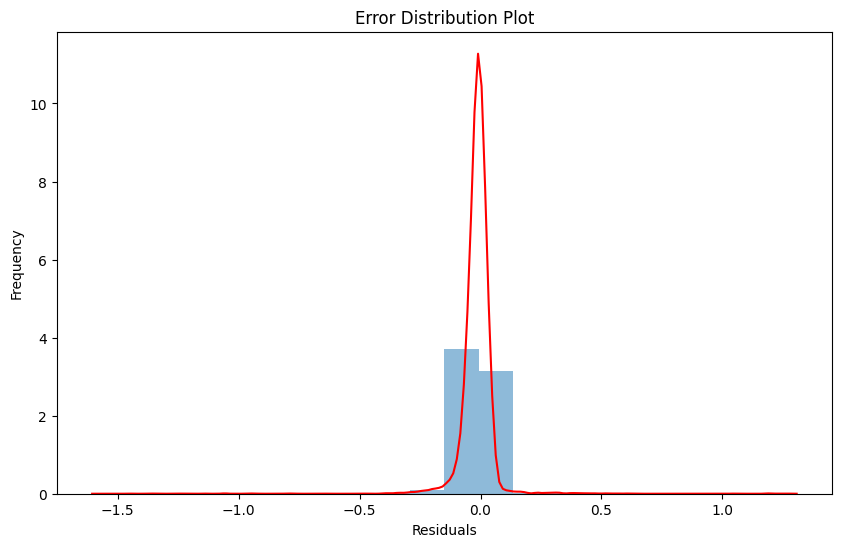

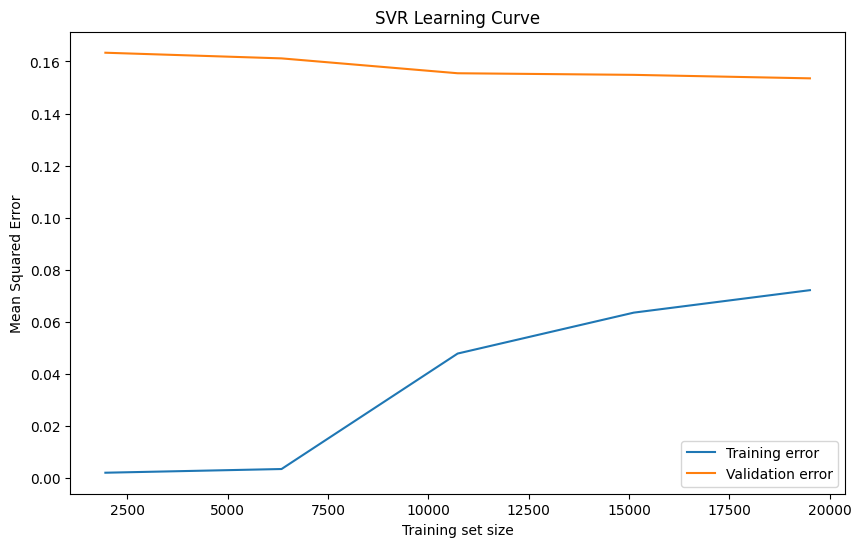

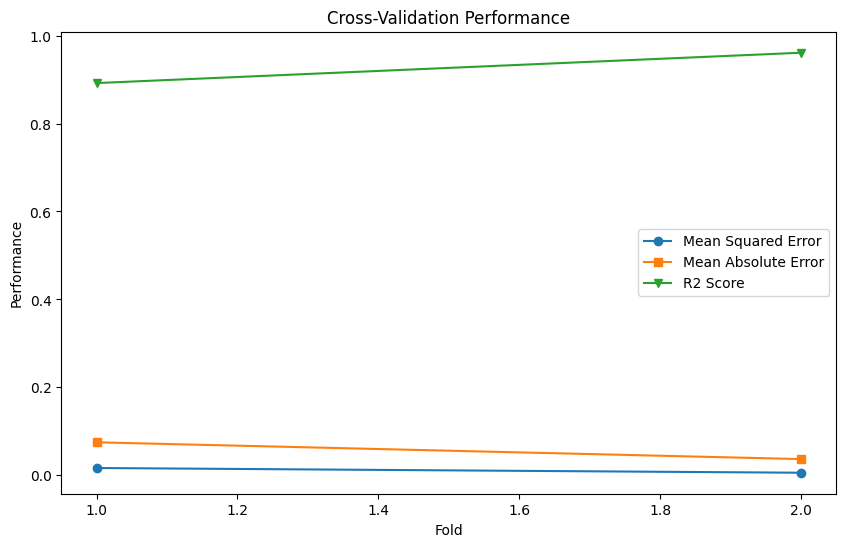

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from functools import partial
from pyswarm import pso
from sklearn.metrics import mean_squared_error, median_absolute_error, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


np.seterr(divide='ignore', invalid='ignore') 

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def predict_ann(X, ann_weights):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights[:-1]):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
        layer_output = leaky_relu(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    # For the last layer, use the identity function
    layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
    layer_output = np.dot(layer_input, ann_weights[-1].T)
    return layer_output.squeeze()

def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights), swarmsize=100, maxiter=300)

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights

def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    layer_input = X_train
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (layer_input.shape[1] + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, layer_input.shape[1] + 1)
        ann_weights.append(layer_weights)
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))  # Add the bias term
        if len(ann_weights) == len(layer_sizes): # Last layer
            layer_output = np.dot(layer_input, layer_weights.T)
        else:
            layer_output = relu(np.dot(layer_input, layer_weights.T))

        layer_input = layer_output
        start = end

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train.squeeze()) ** 2)
    return mse

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Replace df_filtered with your actual DataFrame


df_filtered_copy = df_filtered.copy()

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

X = df_filtered_copy.drop(['mag', 'time'], axis=1).values
y = df_filtered_copy['mag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ---------------------------------------------------
# Define the parameter grid for SVR
svr_params = {
    'C': [10],
    'epsilon': [0.01],
    'gamma': [0.001]
}

svr_search = GridSearchCV(SVR(kernel='rbf'), svr_params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

svr_search.fit(X_train_scaled, y_train)

# Get the best SVR model
best_svr = svr_search.best_estimator_

# Get the SVR predictions
y_train_svr = best_svr.predict(X_train_scaled)
y_test_svr = best_svr.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
input_size = X_train_scaled.shape[1]
hidden_size = int(input_size * 0.5)
X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

# Define layer_sizes and bounds for EPSO
layer_sizes = [15, 10, 5, 1]  # Added an additional hidden layer
bounds = (-0.5, 0.5)

# Initialize k-fold cross-validation
k = 2
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
mse_list = []
mae_list = []
r2_score_list = []
rmse_list = []
mape_list = []
medae_list = []
evs_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------------
    # Train the SVR model
    best_svr.fit(X_train_scaled, y_train)

    # Get the SVR predictions
    y_train_svr = best_svr.predict(X_train_scaled)
    y_test_svr = best_svr.predict(X_test_scaled)


    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
    X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)

    # Append metrics to the corresponding lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_score_list.append(r2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    medae_list.append(medae)
    evs_list.append(evs)

# Calculate average evaluation metrics
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_r2_score = np.mean(r2_score_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)
avg_medae = np.mean(medae_list)
ev_score = np.mean(evs_list)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)
print("Average R2 Score:", avg_r2_score)
print("Average Root Mean Squared Error:", avg_rmse)
print("Average Mean Absolute Percentage Error:", avg_mape)
print("Average Median Absolute Error:", avg_medae)
print("Average Explained Variance Score:", ev_score)

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Scatter Plot of Actual vs. Predicted values")
plt.show()

# Residual Plot
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Error Distribution Plot
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, density=True, alpha=0.5)

residuals = np.where(np.isnan(residuals), 0, residuals)  # replace np.nan with 0
sns.kdeplot(residuals, color='r')

plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Error Distribution Plot")
plt.show()

# Learning Curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training error")
    plt.plot(train_sizes, test_scores_mean, label="Validation error")
    plt.xlabel("Training set size")
    plt.ylabel("Mean Squared Error")
    plt.title(title)
    plt.legend()
    plt.show()

plot_learning_curve(best_svr, X, y, "SVR Learning Curve")

# Cross-validation Performance Plot
folds = np.arange(1, k + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, mse_list, marker='o', label="Mean Squared Error")
plt.plot(folds, mae_list, marker='s', label="Mean Absolute Error")
plt.plot(folds, r2_score_list, marker='v', label="R2 Score")
plt.xlabel("Fold")
plt.ylabel("Performance")
plt.title("Cross-Validation Performance")
plt.legend()
plt.show()



In [67]:
# pip install pandas==1.2.5

Note: you may need to restart the kernel to use updated packages.


### time-based split - Regression Model

In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from functools import partial
from pyswarm import pso
from sklearn.metrics import mean_squared_error, median_absolute_error, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import time  # Add this import


np.seterr(divide='ignore', invalid='ignore')  # Add this line to ignore RuntimeWarnings



def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def predict_ann(X, ann_weights):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights[:-1]):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
        layer_output = leaky_relu(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    # For the last layer, use the identity function
    layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
    layer_output = np.dot(layer_input, ann_weights[-1].T)
    return layer_output.squeeze()

def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights), swarmsize=100, maxiter=300)

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights

def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    layer_input = X_train
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (layer_input.shape[1] + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, layer_input.shape[1] + 1)
        ann_weights.append(layer_weights)
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))  # Add the bias term
        if len(ann_weights) == len(layer_sizes): # Last layer
            layer_output = np.dot(layer_input, layer_weights.T)
        else:
            layer_output = relu(np.dot(layer_input, layer_weights.T))

        layer_input = layer_output
        start = end

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train.squeeze()) ** 2)
    return mse

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Replace df_filtered with your actual DataFrame


df_filtered_copy = df_filtered.copy()

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Split the data based on the 'time' feature
train_data = df_filtered_copy[df_filtered_copy['time'] < '2019-01-01']
test_data = df_filtered_copy[df_filtered_copy['time'] >= '2019-01-01']

# Prepare the training and testing sets
X_train = train_data.drop(['mag', 'time'], axis=1).values
y_train = train_data['mag'].values
X_test = test_data.drop(['mag', 'time'], axis=1).values
y_test = test_data['mag'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ---------------------------------------------------
# Define the parameter grid for SVR
svr_params = {
    'C': [10],
    'epsilon': [0.01],
    'gamma': [0.001]
}

svr_search = GridSearchCV(SVR(kernel='rbf'), svr_params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

svr_search.fit(X_train_scaled, y_train)

# Get the best SVR model
best_svr = svr_search.best_estimator_

# Get the SVR predictions
y_train_svr = best_svr.predict(X_train_scaled)
y_test_svr = best_svr.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
input_size = X_train_scaled.shape[1]
hidden_size = int(input_size * 0.5)
X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

# Define layer_sizes and bounds for EPSO
layer_sizes = [15, 10, 5, 1]  # Added an additional hidden layer
bounds = (-0.5, 0.5)

# Initialize k-fold cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
mse_list = []
mae_list = []
r2_score_list = []
rmse_list = []
mape_list = []
medae_list = []
evs_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------------
    # Train the SVR model
    best_svr.fit(X_train_scaled, y_train)

    # Get the SVR predictions
    y_train_svr = best_svr.predict(X_train_scaled)
    y_test_svr = best_svr.predict(X_test_scaled)


    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
    X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)

    # Append metrics to the corresponding lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_score_list.append(r2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    medae_list.append(medae)
    evs_list.append(evs)

# Calculate average evaluation metrics
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_r2_score = np.mean(r2_score_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)
avg_medae = np.mean(medae_list)
ev_score = np.mean(evs_list)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)
print("Average R2 Score:", avg_r2_score)
print("Average Root Mean Squared Error:", avg_rmse)
print("Average Mean Absolute Percentage Error:", avg_mape)
print("Average Median Absolute Error:", avg_medae)
print("Average Explained Variance Score:", ev_score)



Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average Mean Squared Error: 0.014395202280220037
Average Mean Absolute Error: 0.0777348343411568
Average R2 Score: 0.9032072066231095
Average Root Mean Squared Error: 0.11331375518905391
Average Mean Absolute Percentage Error: 1.609725303652176
Average Median Absolute Error: 0.05968666407640262
Average Explained Variance Score: 0.923764698710432


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average Mean Squared Error: 0.00978968254902782
Average Mean Absolute Error: 0.06623389796431331
Average R2 Score: 0.9353499983104687
Average Root Mean Squared Error: 0.09886385555231232
Average Mean Absolute Percentage Error: 1.365230642835101
Average Median Absolute Error: 0.051639534029116786
Average Explained Variance Score: 0.9377091062753424


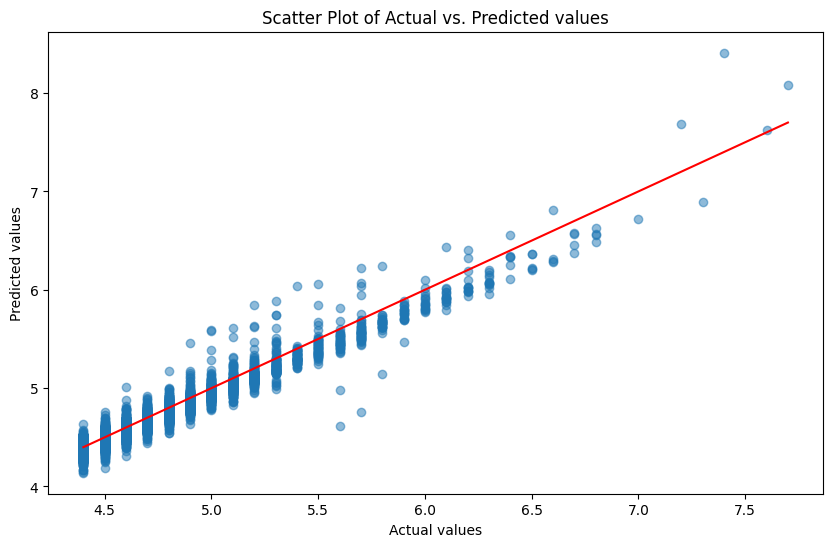

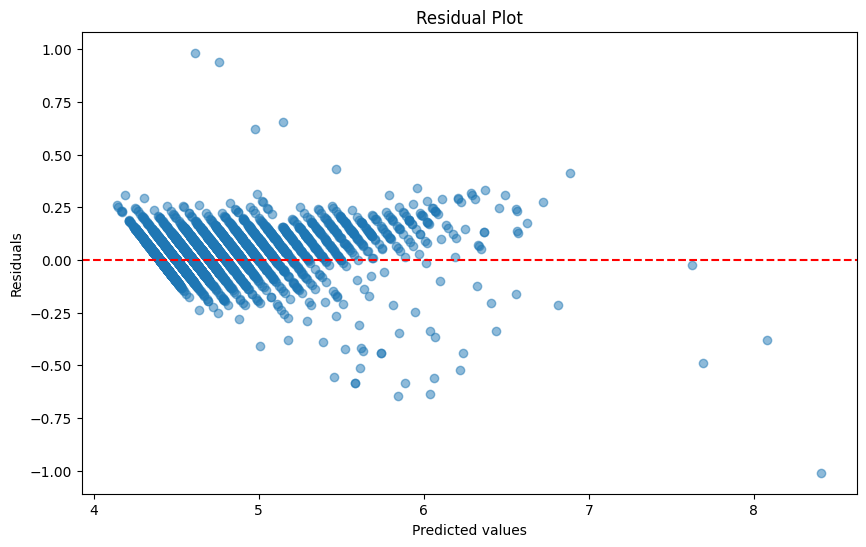

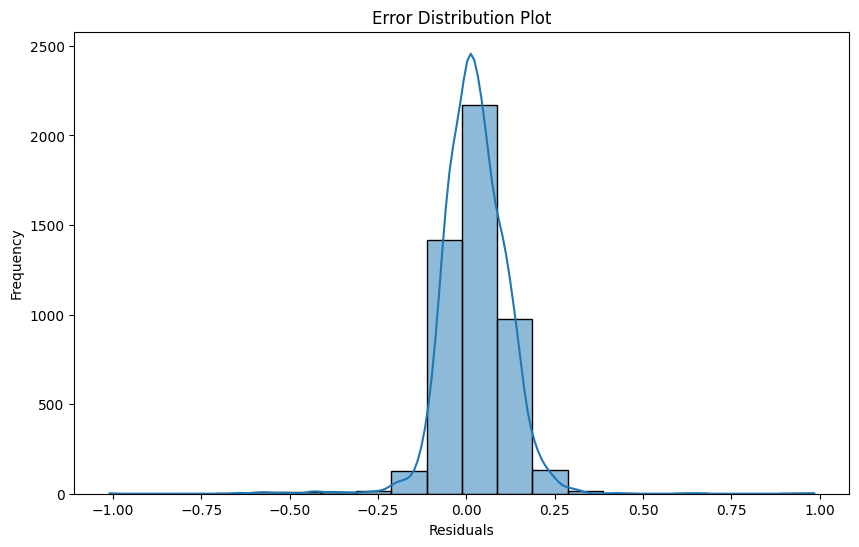

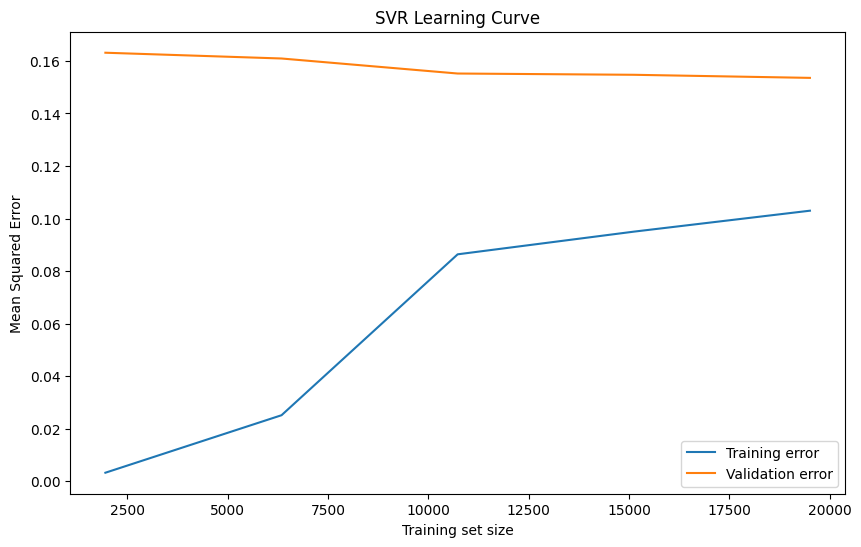

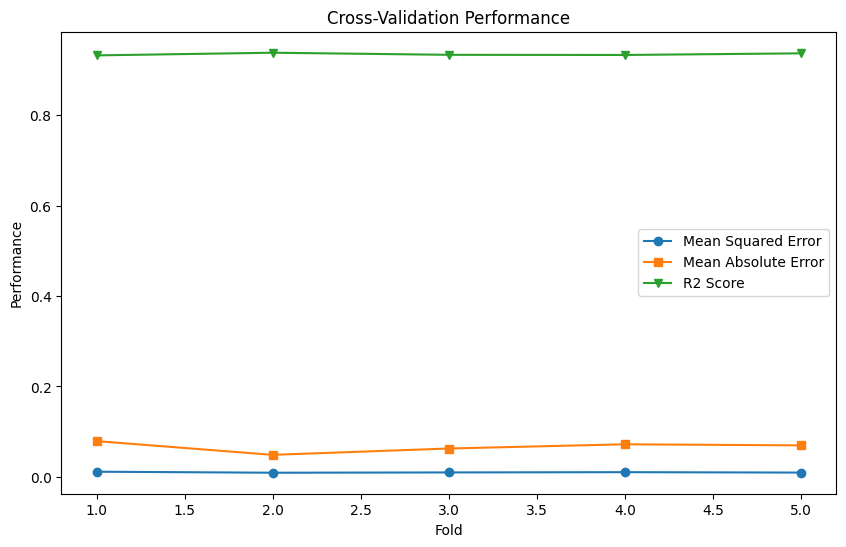

In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from functools import partial
from pyswarm import pso
from sklearn.metrics import mean_squared_error, median_absolute_error, explained_variance_score
from sklearn.model_selection import GridSearchCV
import time 


np.seterr(divide='ignore', invalid='ignore')  # Add this line to ignore RuntimeWarnings

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def predict_ann(X, ann_weights):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights[:-1]):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
        layer_output = leaky_relu(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    # For the last layer, use the identity function
    layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
    layer_output = np.dot(layer_input, ann_weights[-1].T)
    return layer_output.squeeze()

def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights), swarmsize=100, maxiter=300)

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights

def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    layer_input = X_train
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (layer_input.shape[1] + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, layer_input.shape[1] + 1)
        ann_weights.append(layer_weights)
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))  # Add the bias term
        if len(ann_weights) == len(layer_sizes): # Last layer
            layer_output = np.dot(layer_input, layer_weights.T)
        else:
            layer_output = relu(np.dot(layer_input, layer_weights.T))

        layer_input = layer_output
        start = end

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train.squeeze()) ** 2)
    return mse

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Copying the dataframe
df_filtered_copy = df_filtered.copy()

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Split the data based on the 'time' feature
train_data = df_filtered_copy[df_filtered_copy['time'] < '2019-01-01']
test_data = df_filtered_copy[df_filtered_copy['time'] >= '2019-01-01']

# Prepare the training and testing sets
X_train = train_data.drop(['mag', 'time'], axis=1).values
y_train = train_data['mag'].values
X_test = test_data.drop(['mag', 'time'], axis=1).values
y_test = test_data['mag'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ---------------------------------------------------
# Define the parameter grid for SVR
svr_params = {
    'C': [10],
    'epsilon': [0.001],
    'gamma': [0.01]
}

svr_search = GridSearchCV(SVR(kernel='rbf'), svr_params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

svr_search.fit(X_train_scaled, y_train)

# Get the best SVR model
best_svr = svr_search.best_estimator_

# Get the SVR predictions
y_train_svr = best_svr.predict(X_train_scaled)
y_test_svr = best_svr.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
input_size = X_train_scaled.shape[1]
hidden_size = int(input_size * 0.5)
X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

# Define layer_sizes and bounds for EPSO
layer_sizes = [15, 10, 5, 1] 
bounds = (-0.5, 0.5)

# Initialize k-fold cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
mse_list = []
mae_list = []
r2_score_list = []
rmse_list = []
mape_list = []
medae_list = []
evs_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------------
    # Train the SVR model
    best_svr.fit(X_train_scaled, y_train)

    # Get the SVR predictions
    y_train_svr = best_svr.predict(X_train_scaled)
    y_test_svr = best_svr.predict(X_test_scaled)


    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
    X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)

    # Append metrics to the corresponding lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_score_list.append(r2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    medae_list.append(medae)
    evs_list.append(evs)

# Calculate average evaluation metrics
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_r2_score = np.mean(r2_score_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)
avg_medae = np.mean(medae_list)
ev_score = np.mean(evs_list)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)
print("Average R2 Score:", avg_r2_score)
print("Average Root Mean Squared Error:", avg_rmse)
print("Average Mean Absolute Percentage Error:", avg_mape)
print("Average Median Absolute Error:", avg_medae)
print("Average Explained Variance Score:", ev_score)

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Scatter Plot of Actual vs. Predicted values")
plt.show()

# Residual Plot
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Error Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Error Distribution Plot")
plt.show()

# Learning Curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training error")
    plt.plot(train_sizes, test_scores_mean, label="Validation error")
    plt.xlabel("Training set size")
    plt.ylabel("Mean Squared Error")
    plt.title(title)
    plt.legend()
    plt.show()

plot_learning_curve(best_svr, X, y, "SVR Learning Curve")

# Cross-validation Performance Plot
folds = np.arange(1, k + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, mse_list, marker='o', label="Mean Squared Error")
plt.plot(folds, mae_list, marker='s', label="Mean Absolute Error")
plt.plot(folds, r2_score_list, marker='v', label="R2 Score")
plt.xlabel("Fold")
plt.ylabel("Performance")
plt.title("Cross-Validation Performance")
plt.legend()
plt.show()


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average Mean Squared Error: 0.011501117622210792
Average Mean Absolute Error: 0.06115901093711244
Average R2 Score: 0.9230203088668206
Average Root Mean Squared Error: 0.0994177007366063
Average Mean Absolute Percentage Error: 1.2578249015476994
Average Median Absolute Error: 0.04746441323238981
Average Explained Variance Score: 0.9280884938795587


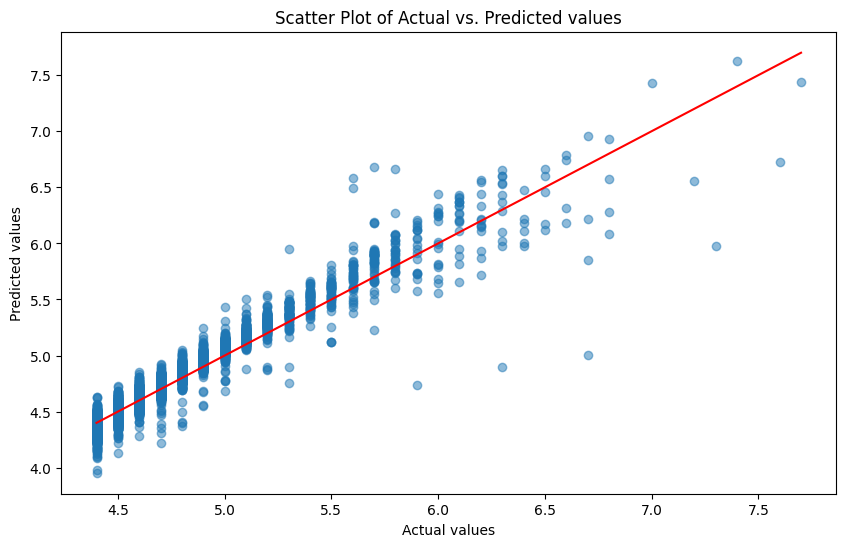

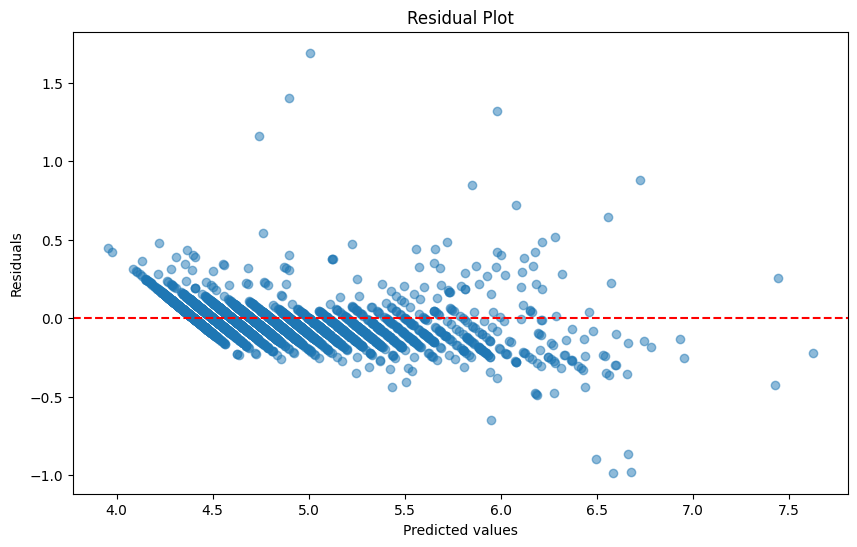

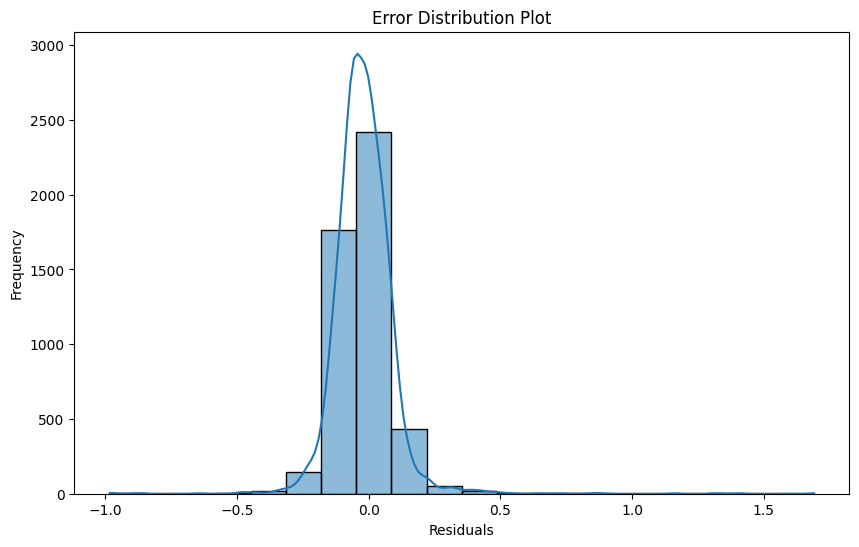

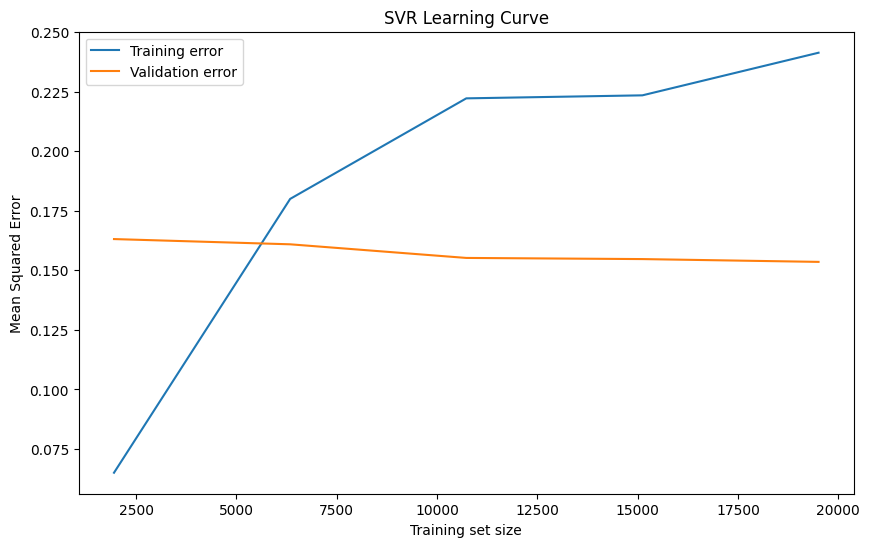

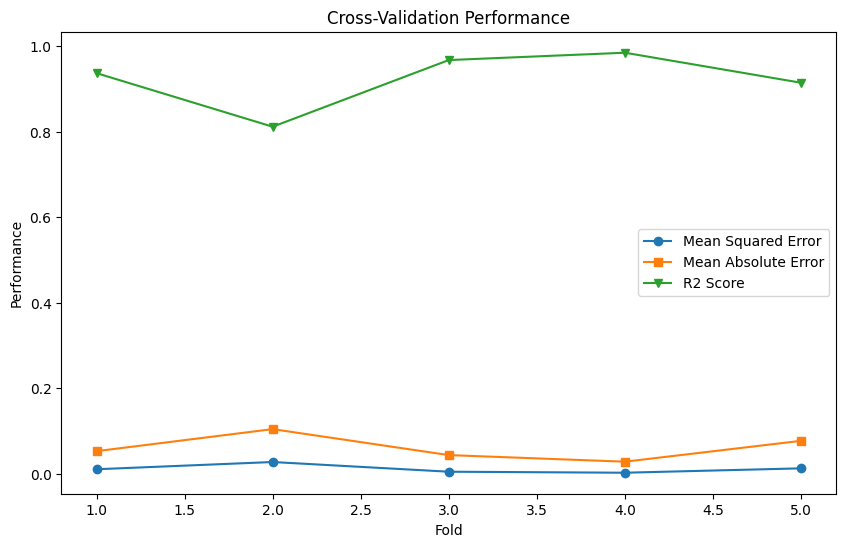

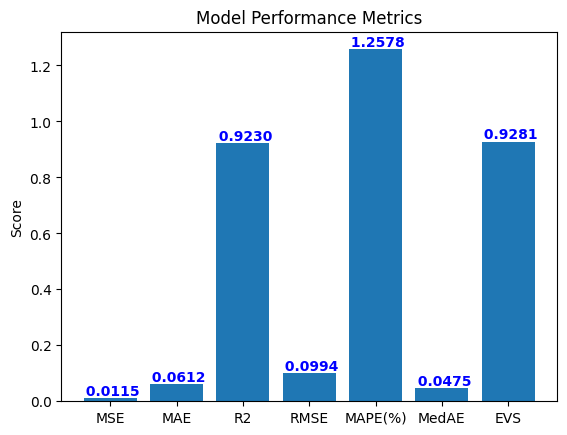

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from functools import partial
from pyswarm import pso
from sklearn.metrics import mean_squared_error, median_absolute_error, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV
import time  # Add this import
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV 

np.seterr(divide='ignore', invalid='ignore')  # Add this line to ignore RuntimeWarnings

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def predict_ann(X, ann_weights):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights[:-1]):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
        layer_output = leaky_relu(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    # For the last layer, use the identity function
    layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
    layer_output = np.dot(layer_input, ann_weights[-1].T)
    return layer_output.squeeze()

def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights), swarmsize=100, maxiter=300)

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights

def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    layer_input = X_train
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (layer_input.shape[1] + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, layer_input.shape[1] + 1)
        ann_weights.append(layer_weights)
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))  # Add the bias term
        if len(ann_weights) == len(layer_sizes): # Last layer
            layer_output = np.dot(layer_input, layer_weights.T)
        else:
            layer_output = relu(np.dot(layer_input, layer_weights.T))

        layer_input = layer_output
        start = end

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train.squeeze()) ** 2)
    return mse

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Replace df_filtered with your actual DataFrame


df_filtered_copy = df_filtered.copy()

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Split the data based on the 'time' feature
train_data = df_filtered_copy[df_filtered_copy['time'] < '2019-01-01']
test_data = df_filtered_copy[df_filtered_copy['time'] >= '2019-01-01']

# Prepare the training and testing sets
X_train = train_data.drop(['mag', 'time'], axis=1).values
y_train = train_data['mag'].values
X_test = test_data.drop(['mag', 'time'], axis=1).values
y_test = test_data['mag'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ---------------------------------------------------
# Define the parameter grid for SVR
svr_params = {
    'C': [10],
    'epsilon': [0.001],
    'gamma': ['auto']
}

svr_search = GridSearchCV(SVR(kernel='rbf'), svr_params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

svr_search.fit(X_train_scaled, y_train)

# Get the best SVR model
best_svr = svr_search.best_estimator_

# Get the SVR predictions
y_train_svr = best_svr.predict(X_train_scaled)
y_test_svr = best_svr.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
input_size = X_train_scaled.shape[1]
hidden_size = int(input_size * 0.5)
X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

# Define layer_sizes and bounds for EPSO
layer_sizes = [15, 10, 5, 1]  # Added an additional hidden layer
bounds = (-0.5, 0.5)

# Initialize k-fold cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
mse_list = []
mae_list = []
r2_score_list = []
rmse_list = []
mape_list = []
medae_list = []
evs_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------------
    # Train the SVR model
    best_svr.fit(X_train_scaled, y_train)

    # Get the SVR predictions
    y_train_svr = best_svr.predict(X_train_scaled)
    y_test_svr = best_svr.predict(X_test_scaled)


    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
    X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)

    # Append metrics to the corresponding lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_score_list.append(r2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    medae_list.append(medae)
    evs_list.append(evs)

# Calculate average evaluation metrics
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_r2_score = np.mean(r2_score_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)
avg_medae = np.mean(medae_list)
ev_score = np.mean(evs_list)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)
print("Average R2 Score:", avg_r2_score)
print("Average Root Mean Squared Error:", avg_rmse)
print("Average Mean Absolute Percentage Error:", avg_mape)
print("Average Median Absolute Error:", avg_medae)
print("Average Explained Variance Score:", ev_score)

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Scatter Plot of Actual vs. Predicted values")
plt.show()

# Residual Plot
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Error Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Error Distribution Plot")
plt.show()

# Learning Curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Training error")
    plt.plot(train_sizes, test_scores_mean, label="Validation error")
    plt.xlabel("Training set size")
    plt.ylabel("Mean Squared Error")
    plt.title(title)
    plt.legend()
    plt.show()

plot_learning_curve(best_svr, X, y, "SVR Learning Curve")

# Cross-validation Performance Plot
folds = np.arange(1, k + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, mse_list, marker='o', label="Mean Squared Error")
plt.plot(folds, mae_list, marker='s', label="Mean Absolute Error")
plt.plot(folds, r2_score_list, marker='v', label="R2 Score")
plt.xlabel("Fold")
plt.ylabel("Performance")
plt.title("Cross-Validation Performance")
plt.legend()
plt.show()

import matplotlib.pyplot as plt

# Define the metrics
metrics = ['MSE', 'MAE', 'R2', 'RMSE', 'MAPE(%)', 'MedAE', 'EVS']
values = [avg_mse, avg_mae, avg_r2_score, avg_rmse, avg_mape, avg_medae, ev_score]

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(metrics, values)
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')

# Annotate the values
for i, v in enumerate(values):
    ax.text(i, v, f" {v:.4f}", ha='center', va='bottom', color='blue', fontweight='bold')

# Show the plot
plt.show()
